### Dodatkowe kody

Heatmapa:

In [1]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


Biblioteki (failsafe):

In [ ]:
#Narzędzia:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

#Klasyfikatory + Ewaluacja

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

#Preprocessing:

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Selekcja Cech:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

#Dodatkowa Wizualizacja:

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

# Określanie Osobowości z tekstu

    Skala MBTI to skala osobowości rozwinieta przez Myersa-Briggsa w celu oepracjonalizacji klasycznych cech osobowości
    by były one bardziej deskryptywne i umożliwiały predykcję zachowań. Skala MBTI opiera się na 4 wymiarach binarnych:
    
        Introwersja (I)- Ekstrawersja (E):
        
            preferencje co do skupiania sie na świecie Wewnętrznym i Zewnętrznym
            
        Intuition (N) - Sensing (S):
        
           Zwracanie uwagi na znaczenie, interpetację, szukanie dodatkowych wyjaśnień vs. 
           Skupianie się na podstawowych informacjach ostarczonych przez zmysły i przydatnych dla mnie
            
        Thinking (T) - Feeling (F):
        
            Podejmowanie Decyzji za pomocą głebokiej Analizy, rozumowania, wiedzy oraz logiki vs.
            podejmowanie decyzji za pomocą własnych intuicji
            
        Judging (J) - Perceivong (P):
        
            W kontaktach ze światem zewnetrznym szybkie i skuteczne podejmowanie decyzji vs.
            otwarcie na nowe doświadczenia i luźny stosunek do pracy
            
        Każdy z tych wymiarów może byc traktowany niezaleznie i nieemergentnie prowadzi do 16 Typów osobowości MBTI.
        
        ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']
       
       Kazdy z tych typów ma swoje własności, ale są one do przewidzenia na podstawie wartosci indywidualnych wymiarów
       
        

### Wczytanie danych, Ekstrakcja Cech oraz Wizualizacja

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Michał\Downloads\mbti-type\mbti_1.csv",sep = ",", engine = "python")
df


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


Wizualizacja udziału klas: Podejrzenie znaczącego efektu niebalansowania

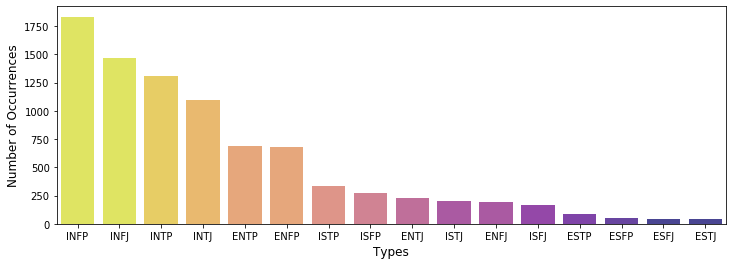

In [6]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

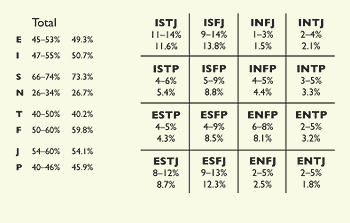

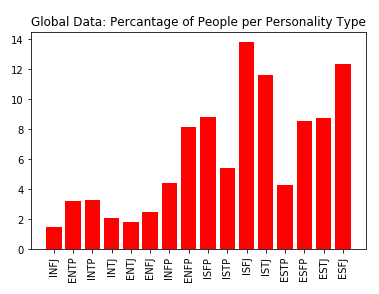

Nasze dane odpowiadają mniej więcej rozkładowi w społeczeństwie

     Z powodu antagonizacji wymiarów binarnych, możemy sie spodziewać, ze coś co może róznicować osoby o różnych Cechach to ilość użytcych słów. Następnym takim czynnikiem może być również ilosć użytych linków (chęć dzielenia sie informacją), mówienie o abstrakcji i personalnych doświadczeniach (muzyka), niepewnosć (np. poprzez ilosć wielokropków), oraz udostępniane obrazki.
     
     Taką cechą może być również mówienie o sobie (użycie 'I')

Z naszych postów ekstraktujemy wybrane Cechy: ilosc słow na osobę, ilość wielokropków, ilośc linków, ilość muzyki, ilość jpgów, ilość użycia 'I'

In [7]:
def words_per_post():

    df['words_per_post'] = 0
    for i in range(len(df.index)):
        df['words_per_post'].loc[i] = len(df["posts"].loc[i].split())/50
        #print(len(df["posts"].loc[i].split())/50)

def Average_frase_per_person(frase):
    df["{} per Post".format(frase)] = 0
    for i in range(len(df.index)):
        df["{} per Post".format(frase)].loc[i]  = df["posts"].loc[i].count(frase)/50
   
    
    


#### Ekstrakcja

In [8]:
#Cecha 1: Ile słów na post używa dana osoba?

words_per_post()
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92
8671,ENFP,'So...if this thread already exists someplace ...,26.18
8672,INTP,'So many questions when i do these things. I ...,18.96
8673,INFP,'I am very conflicted right now when it comes ...,34.10


In [9]:
#Cecha 2: Ile średnio wielokropków na post używa dana osoba?

Average_frase_per_person('...')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42
...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94


In [10]:

#Cecha 3: Ile średnio linków na post używa dana osoba?
Average_frase_per_person('http')
df


C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12
...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00


In [11]:
#Cecha 4: Ile średnio frazy 'Muzyka' na post używa dana osoba?

Average_frase_per_person('music')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00


In [12]:
#Cecha 5: Ile średnio obrazków na post używa dana osoba?

Average_frase_per_person('jpg')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04
...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00


In [13]:
#Cecha 6: Ile średnio SŁowa 'I' na post używa dana osoba?
#Wzięte z Analizy częstości występowania

Average_frase_per_person('I')
df

C:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12,0.46
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02,2.02
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00,0.98
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00,1.74
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04,0.92
...,...,...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,0.14,0.14,0.00,0.02,1.02
8671,ENFP,'So...if this thread already exists someplace ...,26.18,0.82,0.04,0.00,0.00,2.40
8672,INTP,'So many questions when i do these things. I ...,18.96,0.38,0.04,0.00,0.00,0.98
8673,INFP,'I am very conflicted right now when it comes ...,34.10,0.94,0.00,0.00,0.00,3.22


#### Wizualizacja

Zobaczmy na ile wybrane Cechy różnią się pomiędzy grupami. Zwizualizujmy je razem, gdzie podobienstwo bedzie widoczne komparatytywnie

In [14]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))

    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[i])
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[i])
        plt.title(od_czego)
        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show

#wizualizacja poszczególnych Cech dla wybranych typów osobowości

def wykres_osobowosci(od_czego,ticks=(0,5,10,15,20,25,30,35),tyks=[0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    
    typ_osobow = np.unique(df['type'])
    fig,axes = plt.subplots(4,4,figsize=(20,20))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df['type']==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df['type']==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_yticks(tyks)
        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.show

    



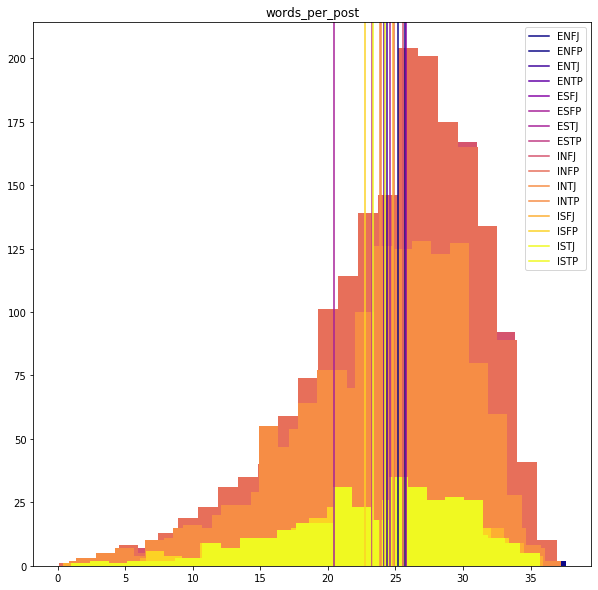

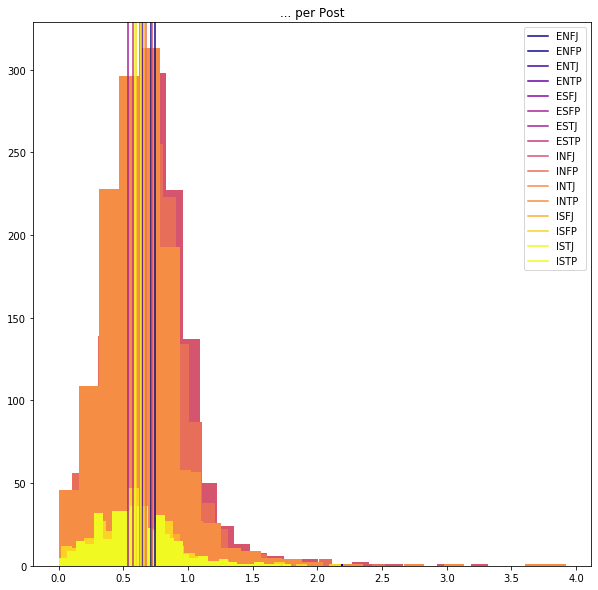

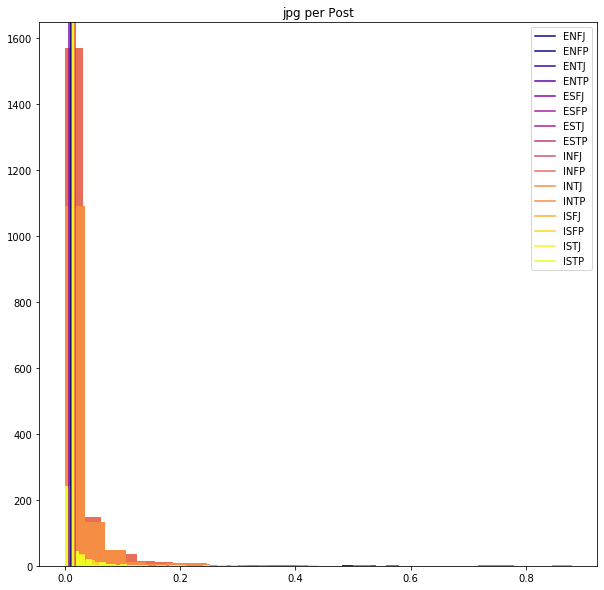

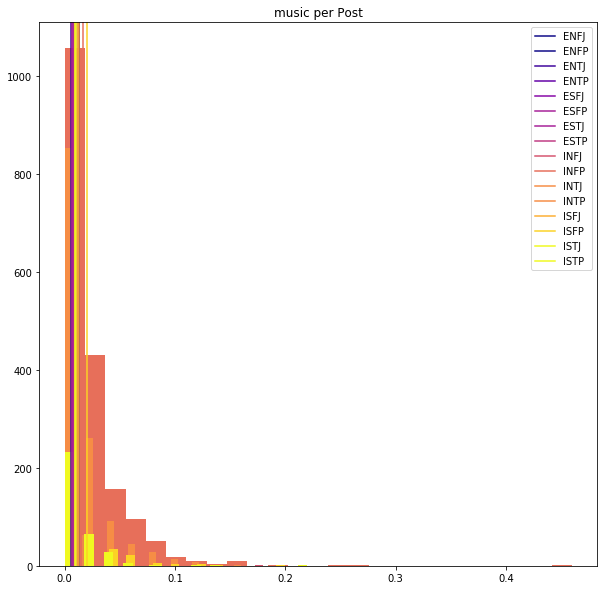

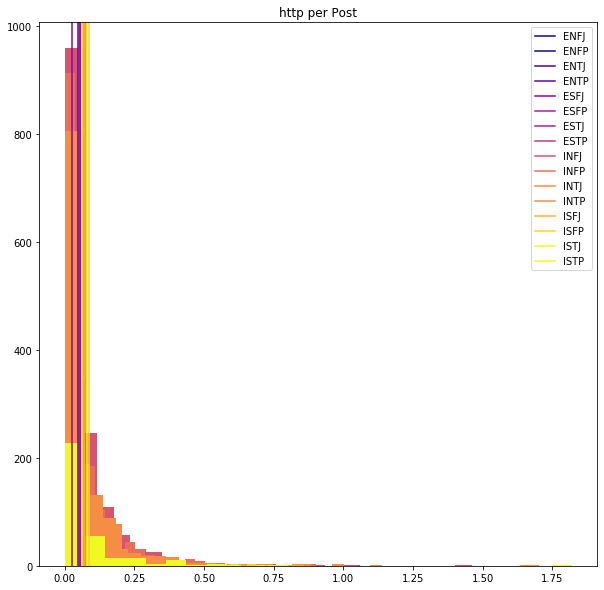

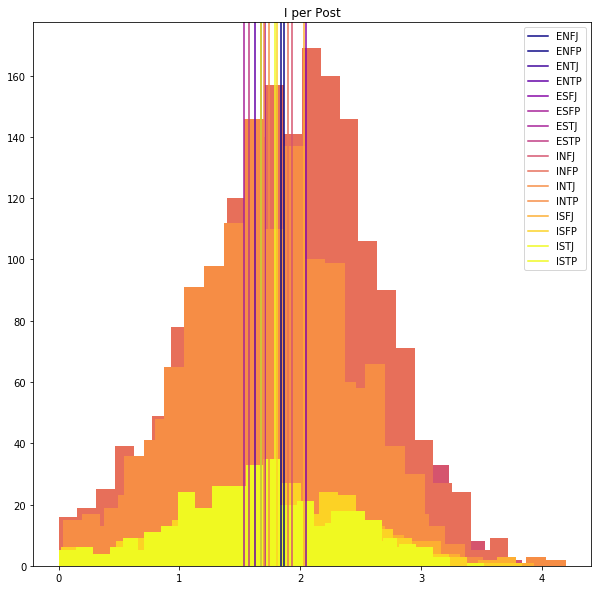

In [15]:
wykres_osobowosci_razem('words_per_post')
wykres_osobowosci_razem('... per Post')
wykres_osobowosci_razem('jpg per Post')
wykres_osobowosci_razem('music per Post')
wykres_osobowosci_razem('http per Post')
wykres_osobowosci_razem('I per Post')

z faktu, że większosc danych sie pokrywa, możemy wnioskowac podobną strukturę. Średnie również nie rożnią się znacząco pomiędzy typami osobowości

Pokażemy osobno każdą Cechę ,żeby to potwierdzić oraz pokażemy średnie

ENFJ: 25.731789473684206
ENFP: 25.21558518518521
ENTJ: 24.361991341991345
ENTP: 24.12002919708029
ESFJ: 25.81
ESFP: 20.4425
ESTJ: 24.59076923076923
ESTP: 23.25191011235956
INFJ: 25.56888435374151
INFP: 24.891266375545865
INTJ: 23.891732355637053
INTP: 23.95547546012269
ISFJ: 24.82590361445782
ISFP: 22.728265682656826
ISTJ: 24.264487804878044
ISTP: 23.3113353115727


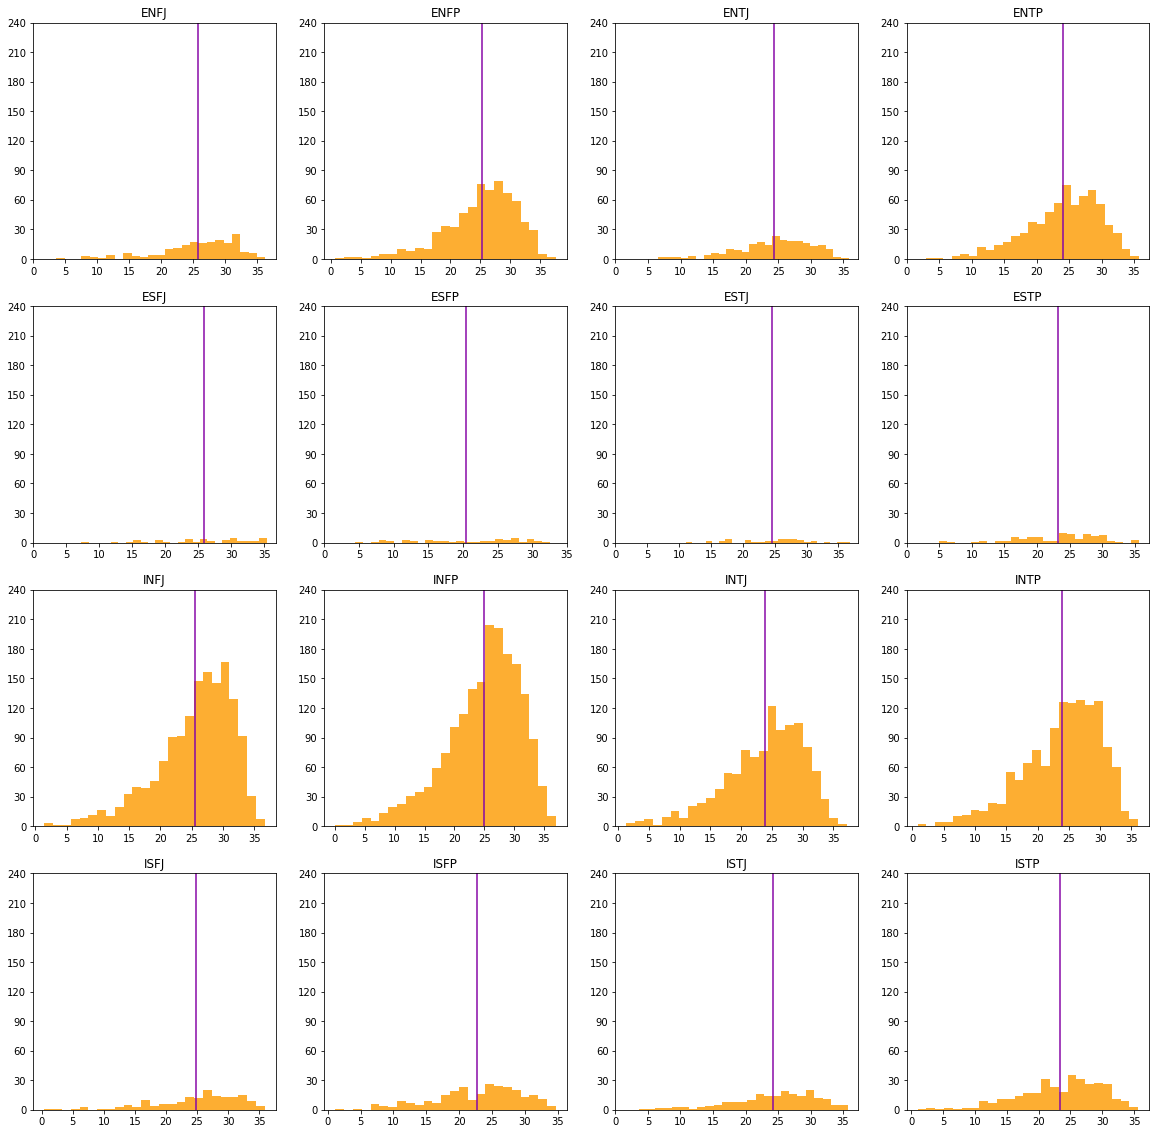

In [16]:
#Ilość słów na post

wykres_osobowosci('words_per_post',tyks=[0,30,60,90,120,150,180,210,240]
)

ENFJ: 0.05326315789473676
ENFP: 0.05045925925925915
ENTJ: 0.05316017316017309
ENTP: 0.048262773722627564
ESFJ: 0.027142857142857146
ESFP: 0.05541666666666667
ESTJ: 0.05282051282051283
ESTP: 0.06471910112359547
INFJ: 0.06587755102040828
INFP: 0.07542576419213985
INTJ: 0.06359303391384065
INTP: 0.07076687116564434
ISFJ: 0.07060240963855414
ISFP: 0.08833948339483383
ISTJ: 0.06117073170731704
ISTP: 0.08100890207715115


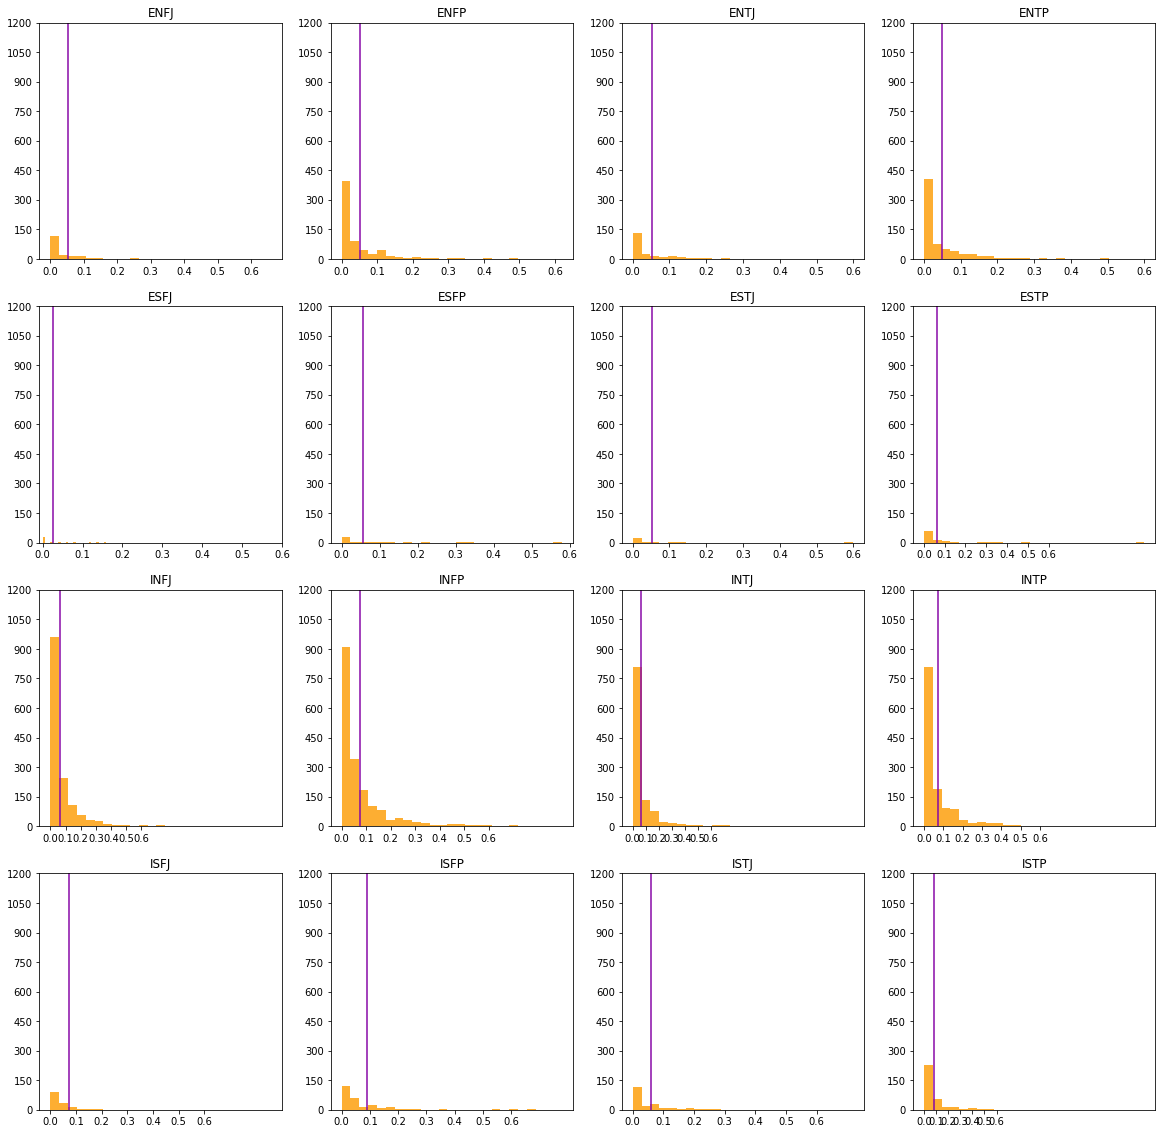

In [17]:
#ilość linków

wykres_osobowosci('http per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.7444210526315788
ENFP: 0.7158814814814816
ENTJ: 0.646666666666667
ENTP: 0.6310364963503654
ESFJ: 0.6385714285714285
ESFP: 0.53375
ESTJ: 0.6307692307692309
ESTP: 0.5775280898876403
INFJ: 0.7214285714285714
INFP: 0.6765938864628811
INTJ: 0.6305407882676447
INTP: 0.6321779141104287
ISFJ: 0.66144578313253
ISFP: 0.5961623616236162
ISTJ: 0.6383414634146342
ISTP: 0.5869436201780414


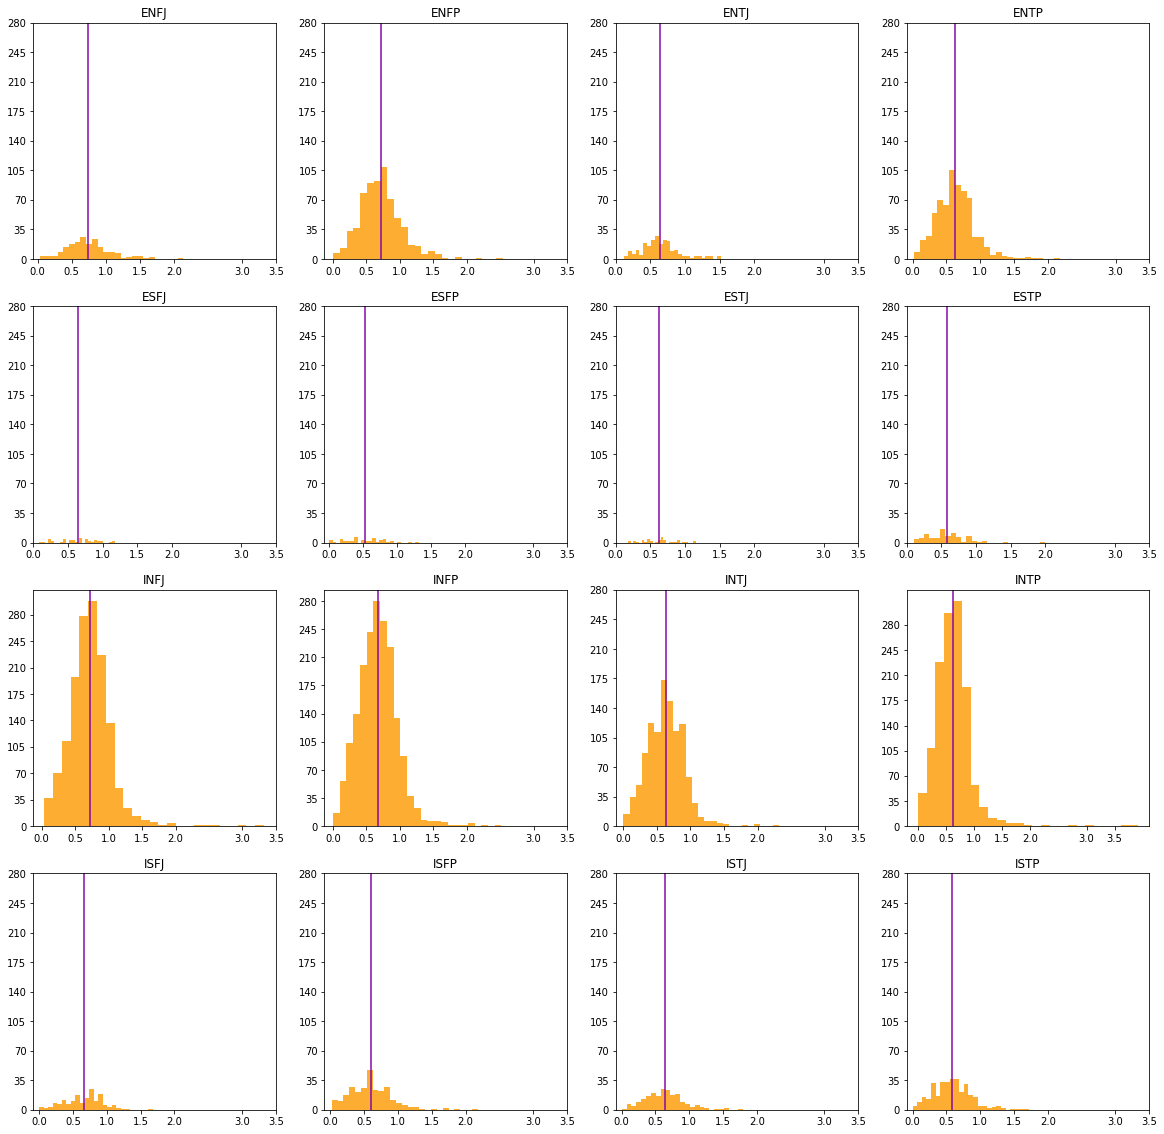

In [18]:
#, ilośc wielokropków

wykres_osobowosci('... per Post',ticks=(0.0,0.5,1.0,1.5,2.0,3.0,3.5),tyks=[0,35,70,105,140,175,210,245,280])


ENFJ: 0.012736842105263164
ENFP: 0.01274074074074069
ENTJ: 0.006147186147186151
ENTP: 0.008671532846715306
ESFJ: 0.007142857142857143
ESFP: 0.007083333333333334
ESTJ: 0.009230769230769232
ESTP: 0.008539325842696632
INFJ: 0.011605442176870663
INFP: 0.01669213973799109
INTJ: 0.009055912007332658
INTP: 0.01277607361963181
ISFJ: 0.011807228915662656
ISFP: 0.020295202952029502
ISTJ: 0.00965853658536586
ISTP: 0.010207715133531164


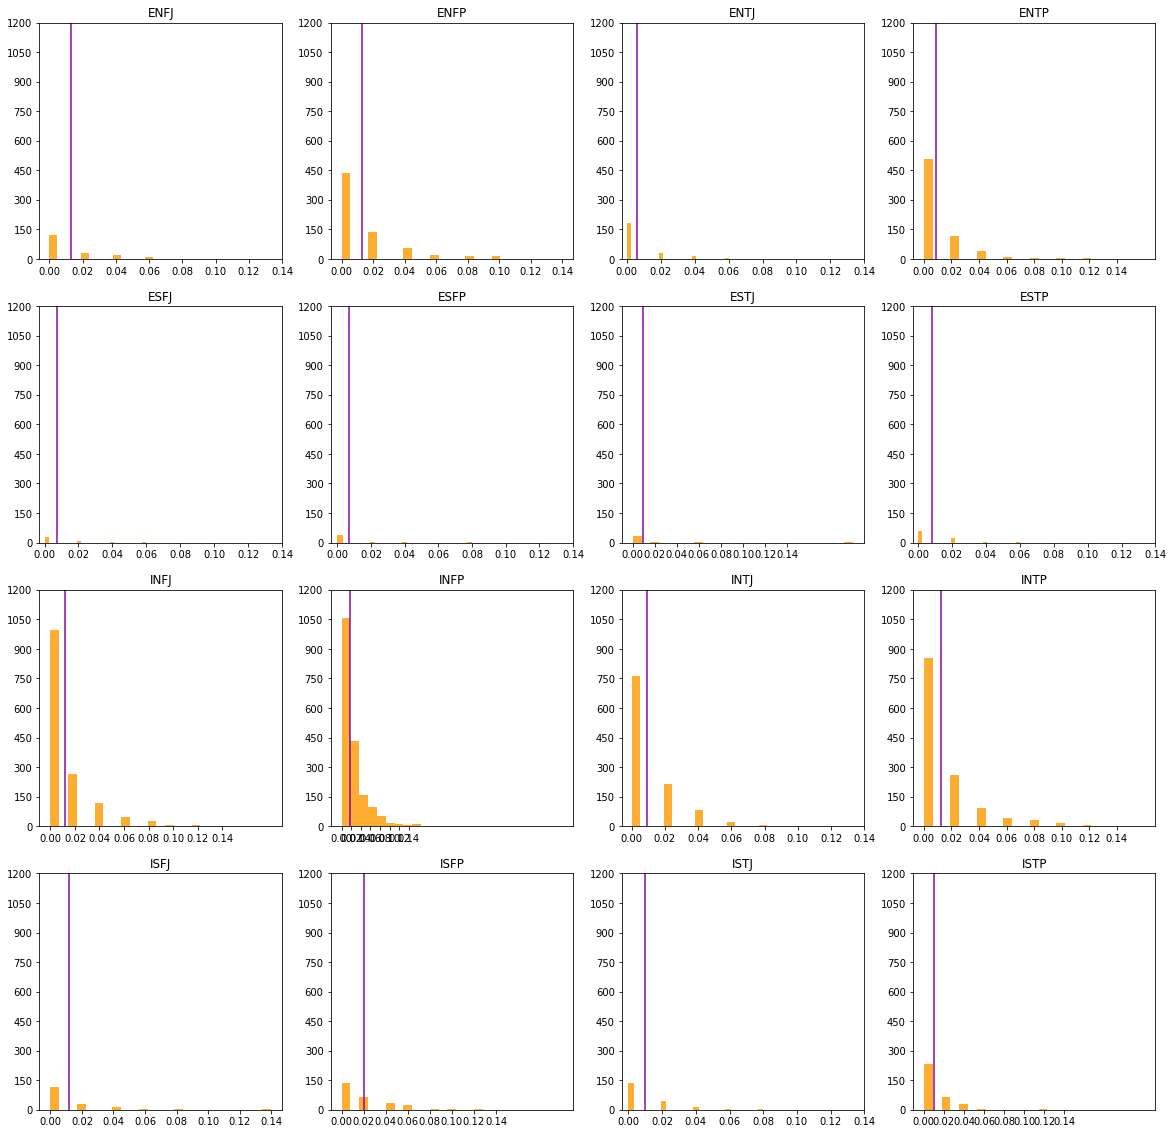

In [19]:
#ilość muzyki

wykres_osobowosci('music per Post',ticks=(0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14),tyks=[0,150,300,450,600,750,900,1050,1200])


ENFJ: 0.011578947368421057
ENFP: 0.01054814814814813
ENTJ: 0.012987012987012993
ENTP: 0.012729927007299227
ESFJ: 0.006666666666666667
ESFP: 0.012500000000000002
ESTJ: 0.01230769230769231
ESTP: 0.01752808988764045
INFJ: 0.012571428571428513
INFP: 0.015534934497816512
INTJ: 0.01470210815765347
INTP: 0.015720858895705434
ISFJ: 0.013975903614457838
ISFP: 0.014612546125461263
ISTJ: 0.013365853658536594
ISTP: 0.014005934718100887


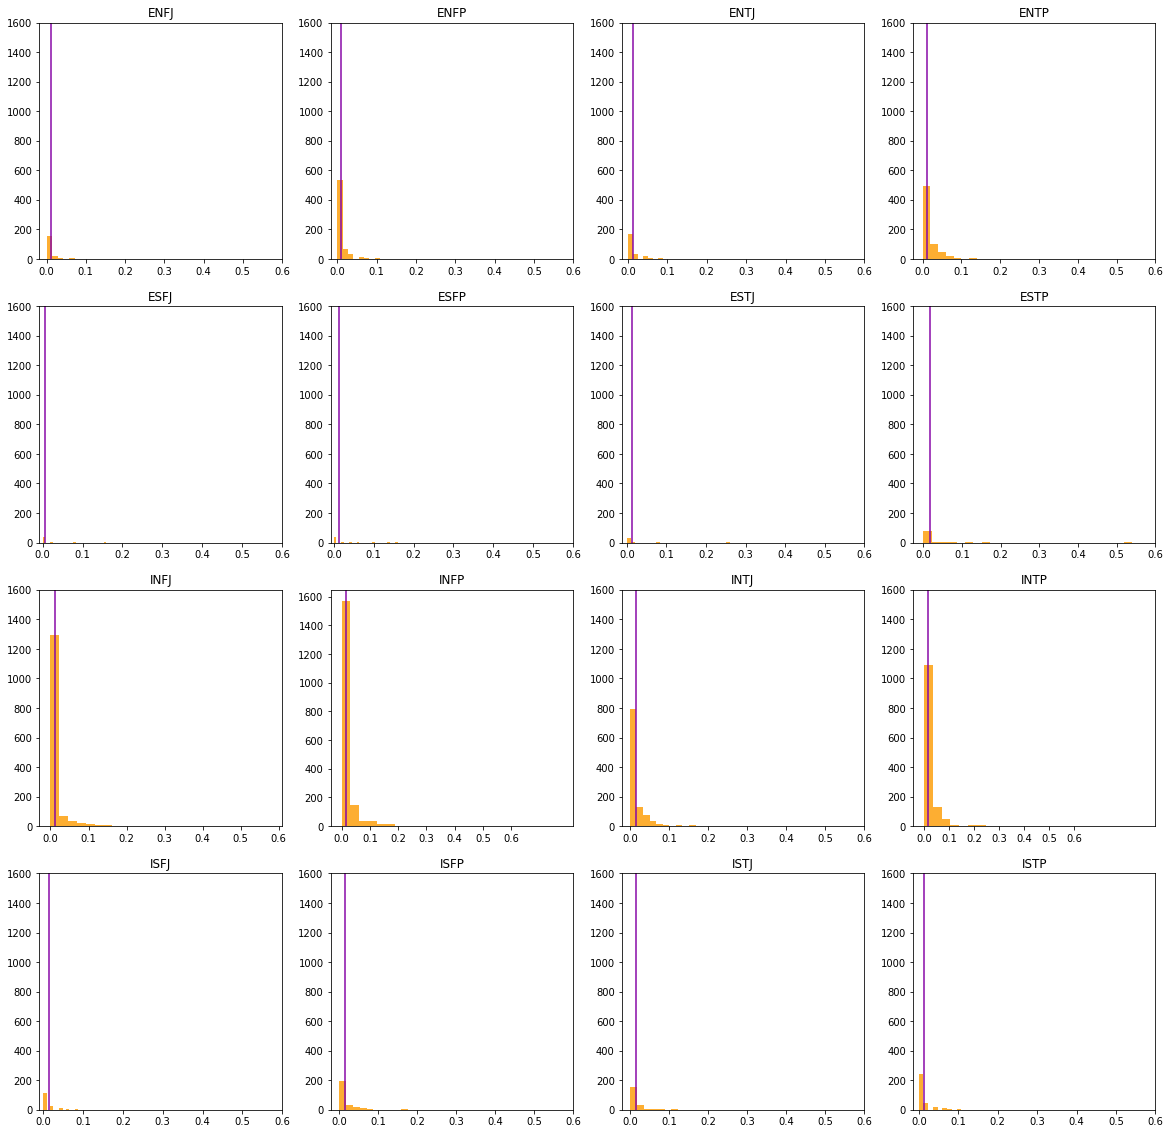

In [20]:
#, ilość jpgów

wykres_osobowosci('jpg per Post',ticks=(0.0,0.1,0.2,0.3,0.4,0.5,0.6),tyks=[0,200,400,600,800,1000,1200,1400,1600])


ENFJ: 1.8402105263157906
ENFP: 1.8632592592592594
ENTJ: 1.6726406926406912
ENTP: 1.629489051094891
ESFJ: 2.0476190476190474
ESFP: 1.5391666666666663
ESTJ: 1.7133333333333336
ESTP: 1.5795505617977532
INFJ: 1.9290884353741473
INFP: 1.8969759825327506
INTJ: 1.6979101741521536
INTP: 1.7457822085889572
ISFJ: 2.0307228915662647
ISFP: 1.8080442804428034
ISTJ: 1.7922926829268289
ISTP: 1.6734718100890196


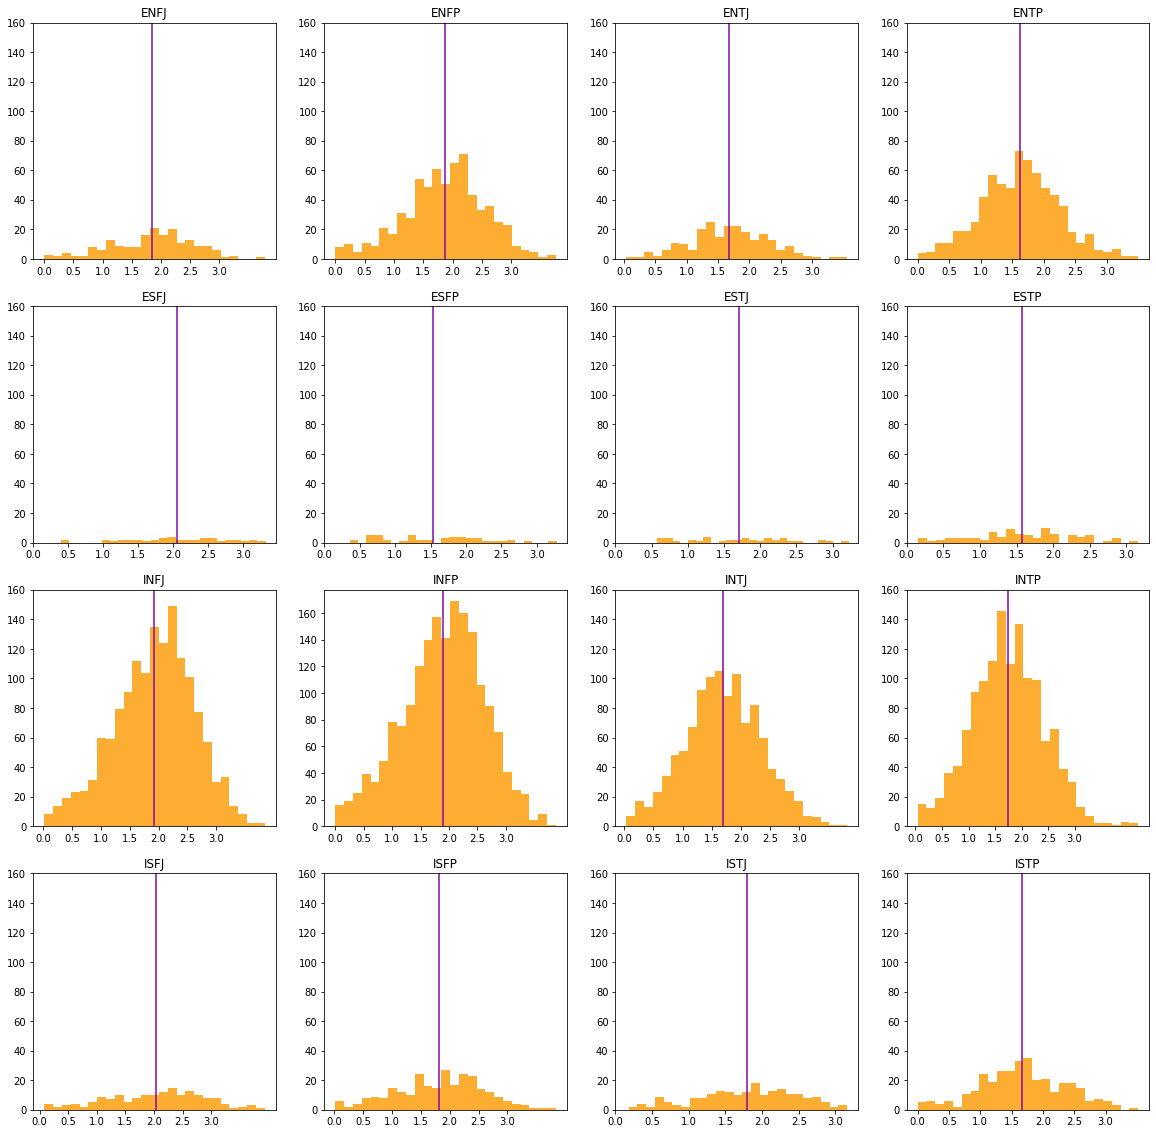

In [22]:
#, ilość użycia 'I'

wykres_osobowosci('I per Post',ticks=(0.0,0.5,1,1.5,2,2.5,3),tyks=[0,20,40,60,80,100,120,140,160])


Widzimy z tego że różnice są widoczne jedynie w Parach cech binarnych

#### Selekcja istotnych Cech

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)



bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print best features

(8675, 6)
(8675,)
            Specs       Score
0  words_per_post  219.272107
5      I per Post   54.593654
1    ... per Post   22.173564
2   http per Post   13.328238
3  music per Post    6.382853
4    jpg per Post    1.907333


Okazuje się że jpg w ogóle nie mają znaczenia a użycie słowa music również nie róznicuje grup

In [18]:
df.drop(['type','posts'], axis=1).corr()

,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post
words_per_post,1.000000,0.694532,-0.420049,0.045314,-0.229499,0.709836
... per Post,0.694532,1.000000,-0.245076,0.026490,-0.120342,0.465793
http per Post,-0.420049,-0.245076,1.000000,0.089092,0.539560,-0.294472
music per Post,0.045314,0.026490,0.089092,1.000000,0.003052,0.064607
jpg per Post,-0.229499,-0.120342,0.539560,0.003052,1.000000,-0.173834
I per Post,0.709836,0.465793,-0.294472,0.064607,-0.173834,1.000000


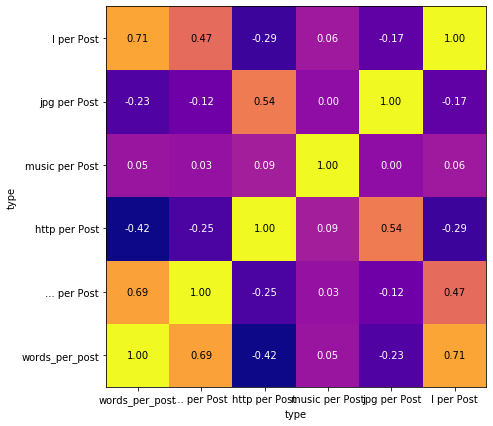

In [42]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

Wynika z tego że najbardziej istotne będą cechy: words per post, ... per post oraz I per post

**Dalsza Analiza pokazał jednak znikomy wpływ selekcji cech na wydajność modelu**

### rozpoznanie osobowości MBTI --> pokazanie koniecznośc Resamplingu


In [35]:
XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)


(8675, 6)
(8675,)
(868, 6)


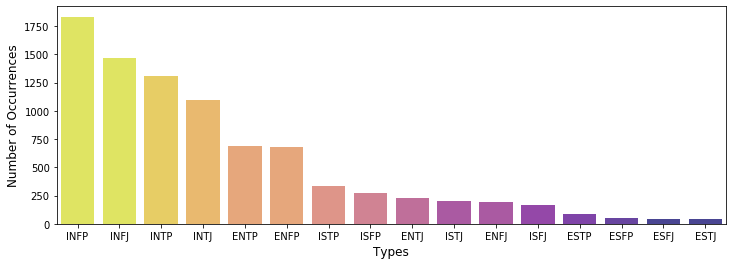

In [23]:

#Wizualizacja udziału Klas

from matplotlib import cm

cnt_srs = df['type'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [41]:
#Przykładowy model --> jeden ze zwróconych przez Grid

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

logreg3 = SVC(kernel ='rbf', gamma= 0.1, C=0.1,probability = True)
logreg3.fit(X_train[:,[0,1,5]],y_train)


from sklearn import metrics

print(metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])))
print(metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='micro'))

0.20046082949308755
0.20046082949308755


Bez Selekcji;

    0.20046082949308755
    0.20046082949308755

In [46]:
print("R^2: {}".format(metrics.precision_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, logreg3.predict(X_test[:,[0,1,5]]),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, logreg3.predict(X_test[:,[0,1,5]])) ))

C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


R^2: 0.012528801843317972
recall_score: 0.0625
f1_score: 0.02087332053742802
accuracy_score: 0.20046082949308755


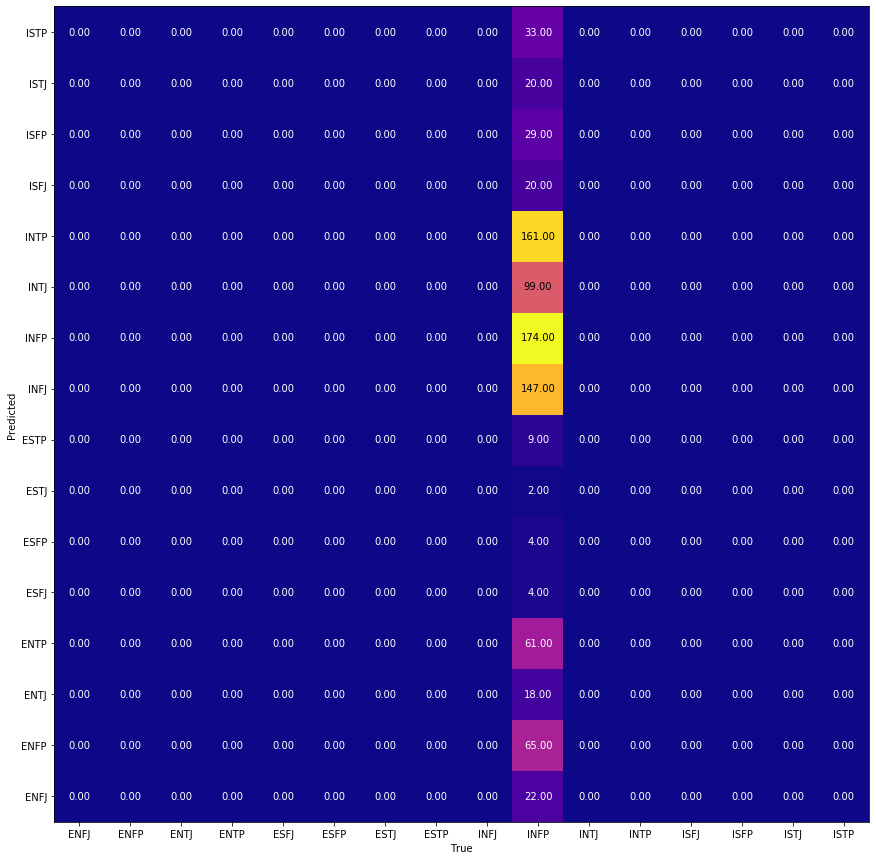

In [39]:
#print(metrics.confusion_matrix(y_test, logreg3.predict(X_test[:,[0,1,2,3,5]])))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, logreg3.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

Jak Widać przydzielono tylko i wyłącznie do jednej klasy

### Resampling 

In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

nm1 = NearMiss(version=1)
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#X_test_res, y_test_res = sm.fit_sample(X_test, y_test)

#print(y_train_res)
print(y_test.shape)

C:\Program Files (x86)\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(8675, 6)
(8675,)
(868,)


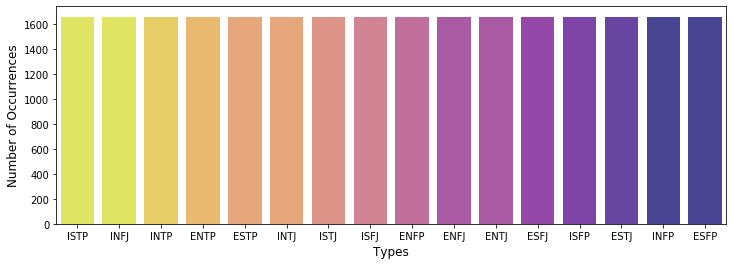

In [44]:
#Wizualizacja Zresamplowanych Klas

df_res = pd.DataFrame(X_train_res)
df_res.columns = ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post']
df_res["type"] = y_train_res


cnt_srs = df_res["type"].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [54]:
#Feature Selection

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X_train_res,y_train_res)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop(['type','posts'], axis=1).columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))  #print 10 best features

            Specs        Score
0  words_per_post  1766.115205
5      I per Post   298.005149
1    ... per Post   105.801881
2   http per Post    79.466595
3  music per Post    25.600825
4    jpg per Post    10.796224


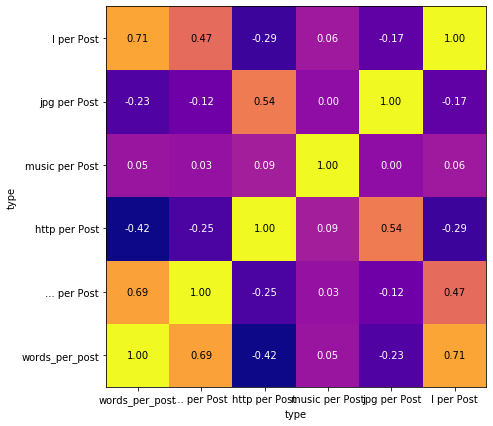

In [51]:
plt.figure(figsize = (7,7))
heatmap(df.drop(['type','posts'], axis=1).corr(), xlabel = 'type', ylabel ='type', xticklabels=['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], yticklabels= ['words_per_post','... per Post','http per Post','music per Post','jpg per Post','I per Post'], cmap='plasma',
            vmin=None, vmax=None, ax=None, fmt="%0.2f")

3 bajważniejsze Cechy nie zmeniły się

In [45]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics


XX = df.drop(['type','posts'], axis=1).values
yy = df['type'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [50]:
#Best Clssificator:
from sklearn.ensemble import ExtraTreesClassifier
Classif_res_Type = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators = 400)
Classif_res_Type.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Type.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Type.predict(X_test)) ))

R^2: 0.06343662450384041
recall_score: 0.0940658819800082
f1_score: 0.055772236475589904
accuracy_score: 0.08064516129032258


Selekcja Cech:

    R^2: 0.06337332946630916
    recall_score: 0.057190302764957616
    f1_score: 0.03632682063032406
    accuracy_score: 0.038018433179723504

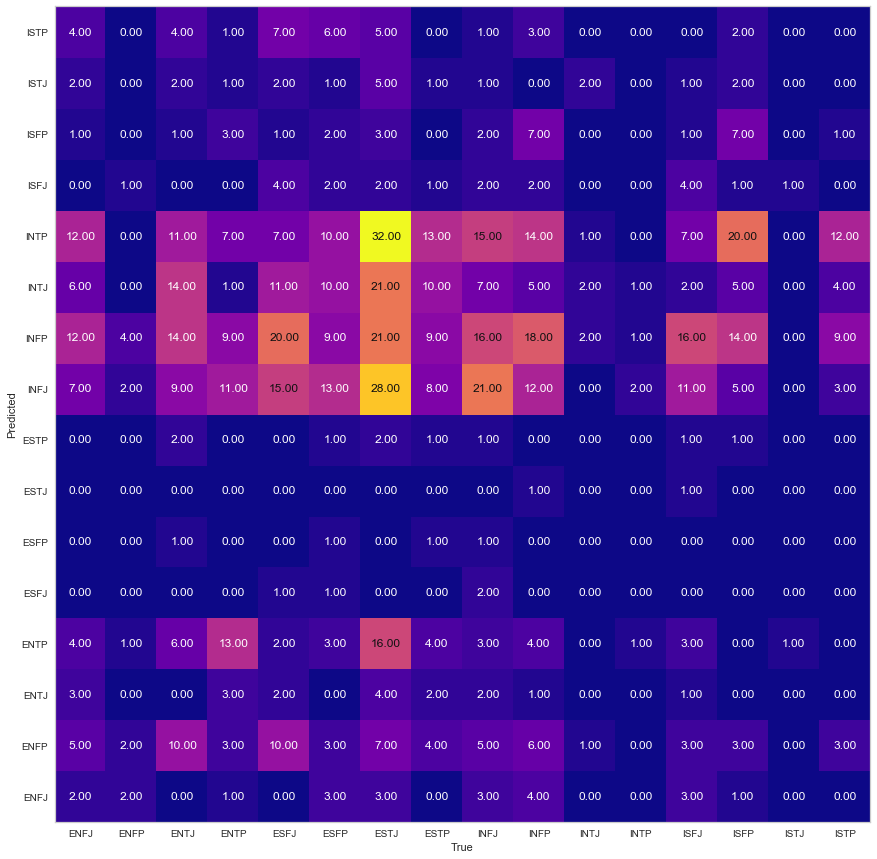

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Type.predict(X_test[:,[0,1,5]]))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Klasyfikacja Typów osobowości osiąga żałosne rezultaty: Sprawdźmy czy jeśli nie wybierzemy Cech manualnie coś się zmieni!

### Automatyczna Selekcja Cech

In [37]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



In [38]:

#Czyścimy zbiór Danych z  niepotrzebnych linków itp.

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)


In [39]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)


(8675,)
(8675,)


In [40]:
#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)



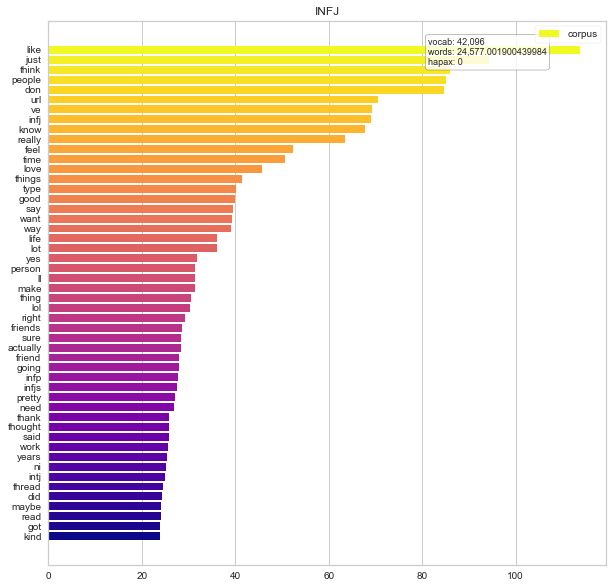

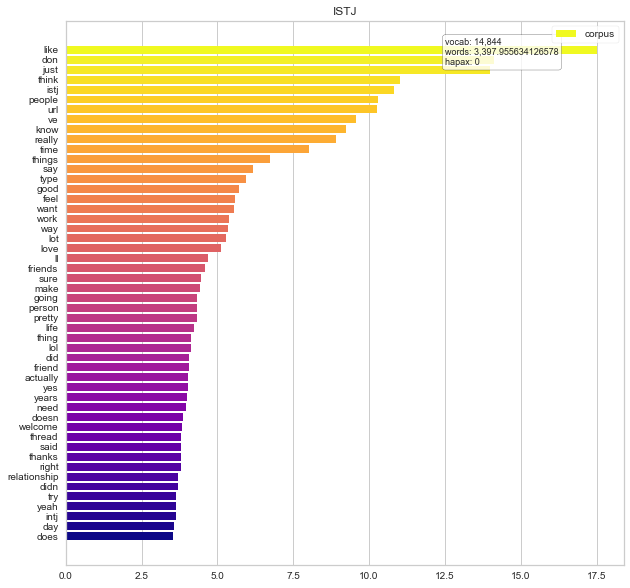

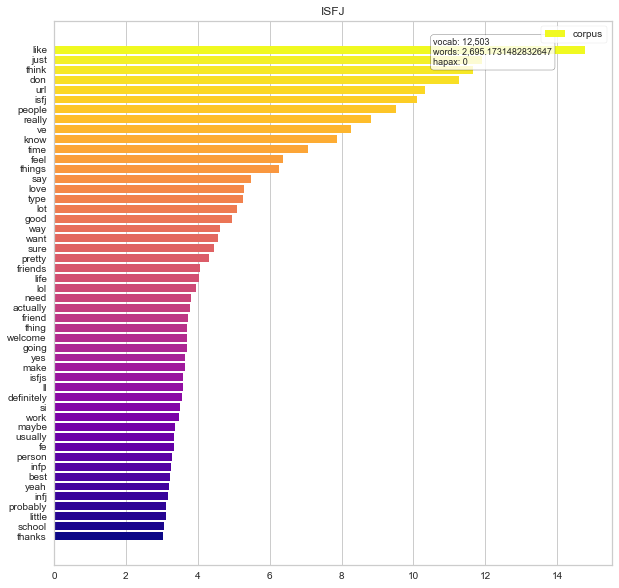

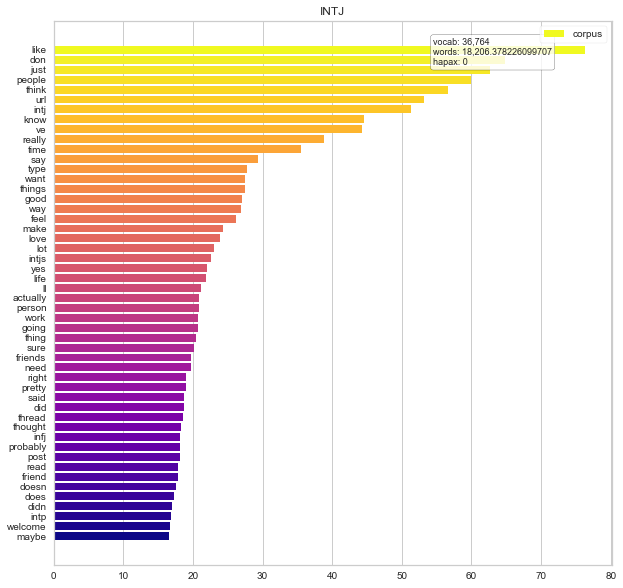

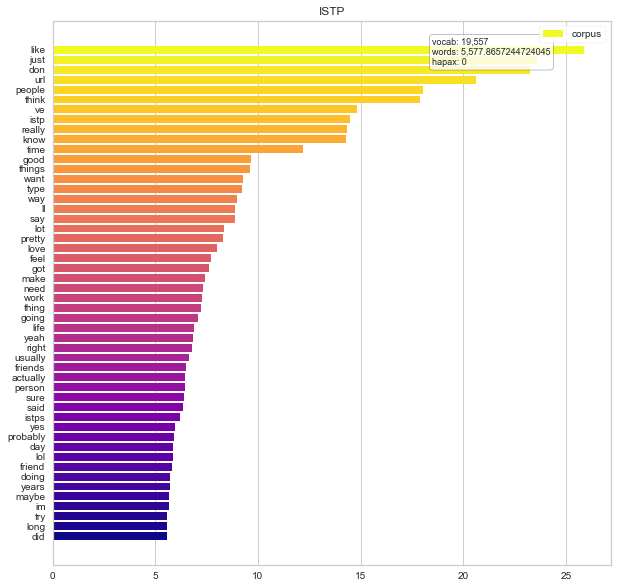

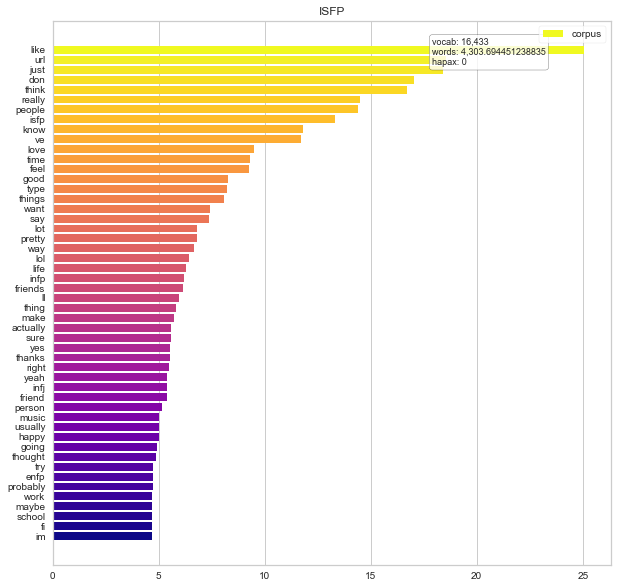

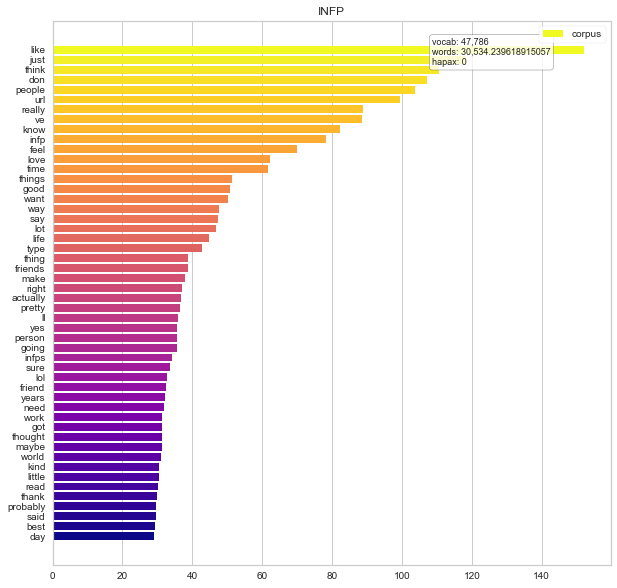

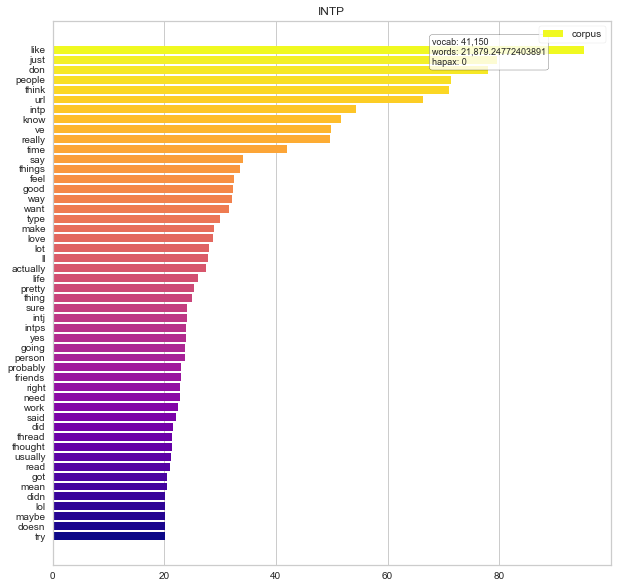

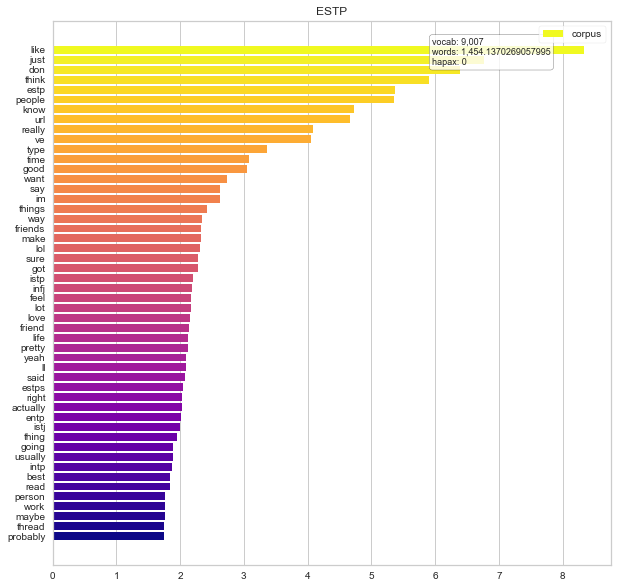

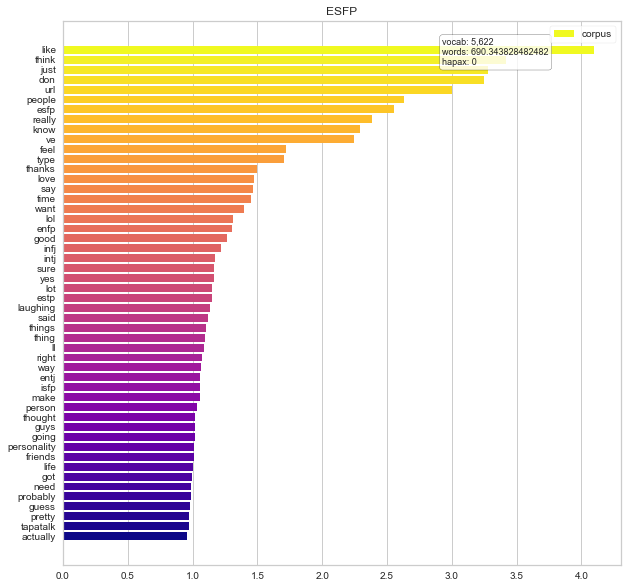

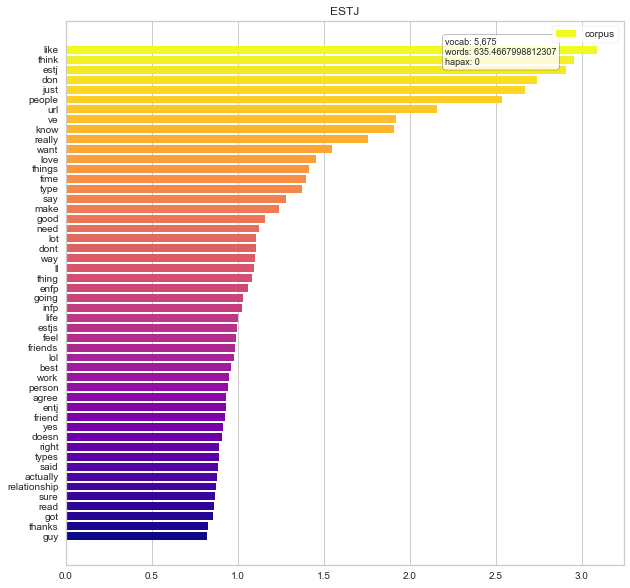

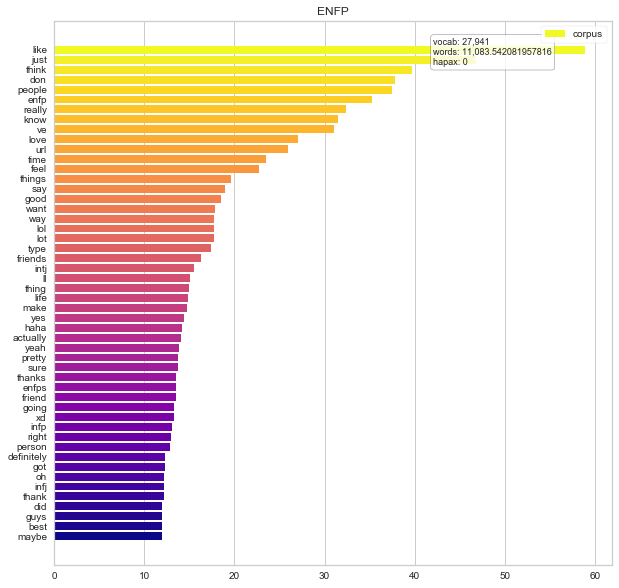

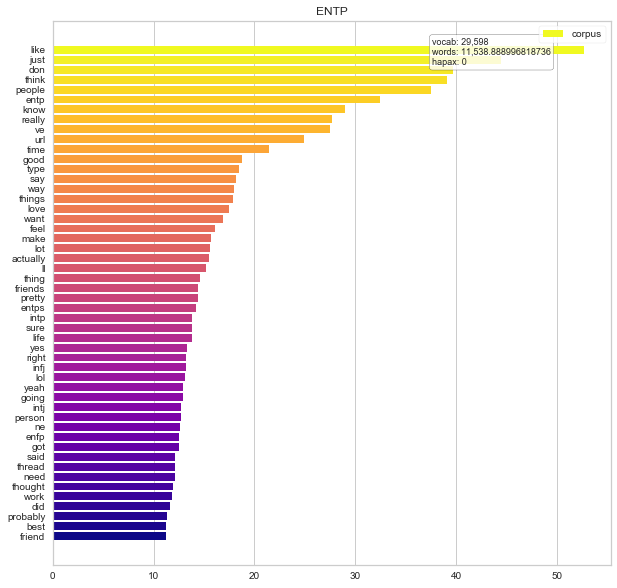

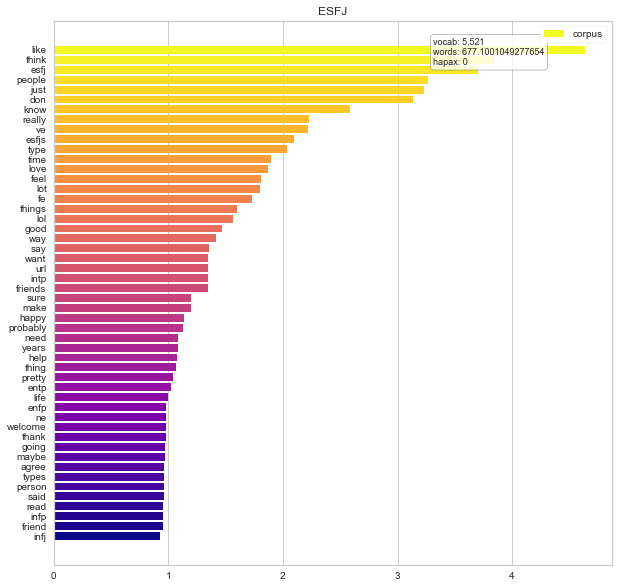

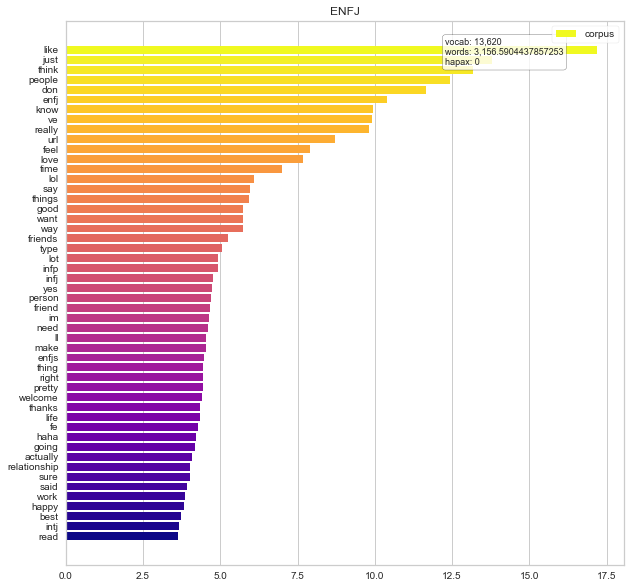

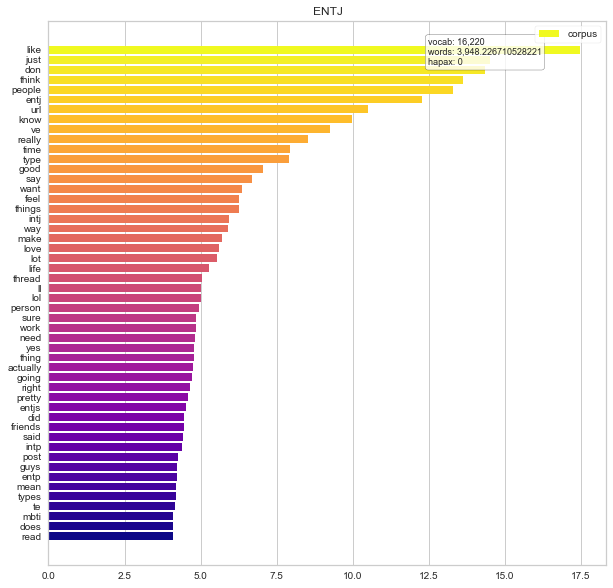

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types):
    XXX = df['clean_posts'].loc[df["type"] == types].values
    
    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 50)
    colors = viridis(np.flip(np.linspace(0, 1, 50)))
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
    
Most_frequent_words_in_Group('INFJ')
Most_frequent_words_in_Group('ISTJ')
Most_frequent_words_in_Group('ISFJ')
Most_frequent_words_in_Group('INTJ')
Most_frequent_words_in_Group('ISTP')
Most_frequent_words_in_Group('ISFP')
Most_frequent_words_in_Group('INFP')
Most_frequent_words_in_Group('INTP')
Most_frequent_words_in_Group('ESTP')
Most_frequent_words_in_Group('ESFP')
Most_frequent_words_in_Group('ESTJ')
Most_frequent_words_in_Group('ENFP')
Most_frequent_words_in_Group('ENTP')
Most_frequent_words_in_Group('ESFJ')
Most_frequent_words_in_Group('ENFJ')
Most_frequent_words_in_Group('ENTJ')




Analiza tfiDF wskazuje na podobne częstosci wystepywania tych samych słów  w poszczególnych Typach

In [59]:
XX = df['clean_posts'].values
yy = df['type'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised_train = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(data_revitalised_train, y_train)


(8675,)
(8675,)


In [67]:
#Best Clssificators:

Classif_res_Automatic_IE = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators = 1000)
Classif_res_Automatic_IE.fit(X_train_res, y_train_res)

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test)) ))

R^2: 0.06259669264384313
recall_score: 0.05892457884289471
f1_score: 0.04603408618083722
accuracy_score: 0.07142857142857142


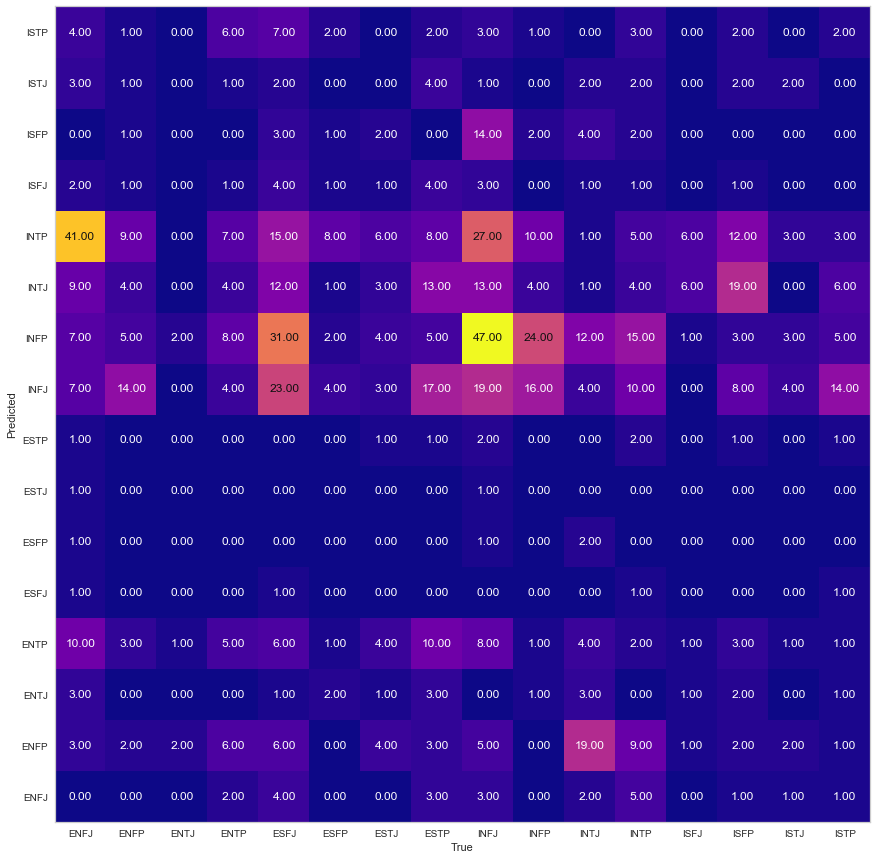

In [69]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, Classif_res_Automatic_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (15,15))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

Jak widać nie zdaje to Egzaminu:

## Poszczególne Cechy --> Klasyfikacja z Resamplingiem!

    Skoro typy osobowości nie wynikaja emergentnie z cech osobowosci, mozemy je analizować niezależnie. Sprawdźmy na ile uda nam sie zrobic klasyfikator poszczególnych Cech.
    
    Oznaczenia:
    
          Introwersja - 0  Ekstrawersja - 1
          Intuition - 0  Sensing - 1
          Thinking - 0  Feeling - 1
          Judging - 0  Perceiving - 1
          
     Czemu tak? By klasy o mniejszym przydziale były klasą pozytywną, a tym samym zmienić postrzeganie Recall i Precision

In [24]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}
df['I-E'] = df['type'].astype(str).str[0]
df['I-E'] = df['I-E'].map(map1)
df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)
df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)
df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)
df.head(10)

,type,posts,words_per_post,... per Post,http per Post,music per Post,jpg per Post,I per Post,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,0.30,0.48,0.02,0.12,0.46,0,0,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,0.38,0.20,0.00,0.02,2.02,1,0,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,0.26,0.10,0.00,0.00,0.98,0,0,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,0.52,0.04,0.02,0.00,1.74,0,0,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,0.42,0.12,0.02,0.04,0.92,1,0,0,0
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,29.82,0.78,0.02,0.00,0.00,1.88,0,0,0,0
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",26.58,0.74,0.04,0.02,0.00,1.88,0,0,1,0
7,INTJ,'I tend to build up a collection of things on ...,24.46,0.56,0.02,0.04,0.00,0.32,0,0,0,0
8,INFJ,"I'm not sure, that's a good question. The dist...",14.76,0.34,0.46,0.02,0.02,0.98,0,0,1,0
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,24.66,0.48,0.14,0.02,0.00,0.20,0,0,0,1


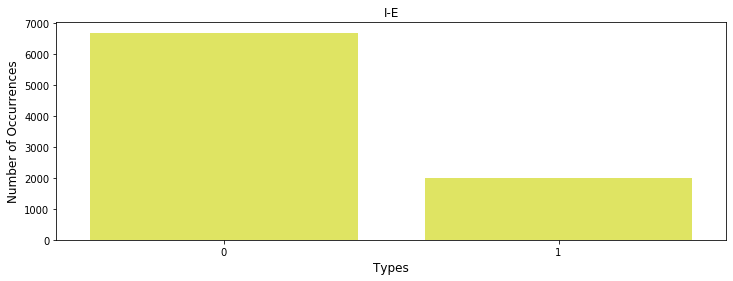

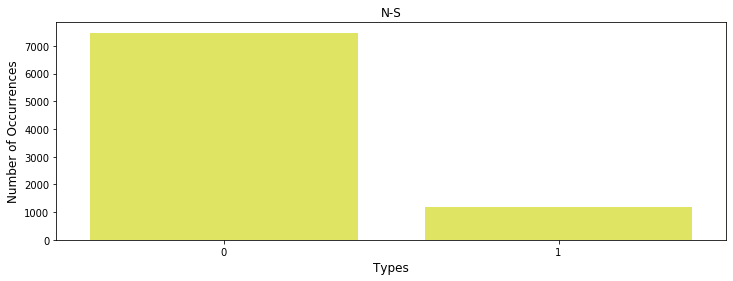

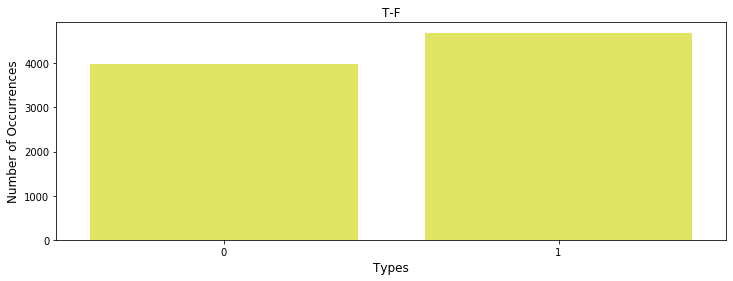

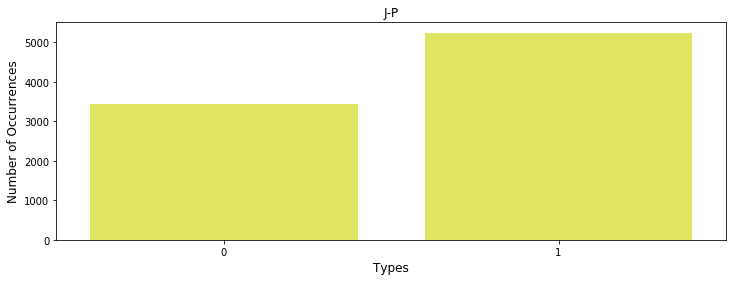

In [25]:
from matplotlib import cm

cnt_srs = df['I-E'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('I-E')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['N-S'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.title('N-S')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['T-F'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('T-F')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

from matplotlib import cm

cnt_srs = df['J-P'].value_counts()
viridis = cm.get_cmap('plasma', 12)
colors = viridis(np.flip(np.linspace(0, 1, 16)))
plt.figure(figsize=(12,4))
plt.title('J-P')
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8,palette=colors)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

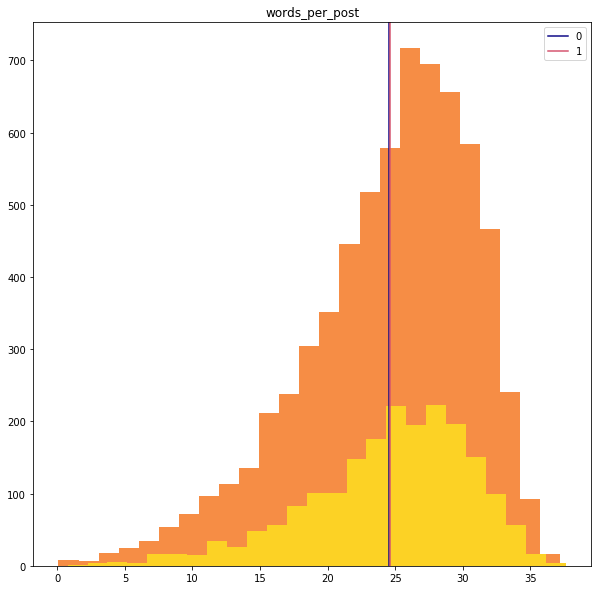

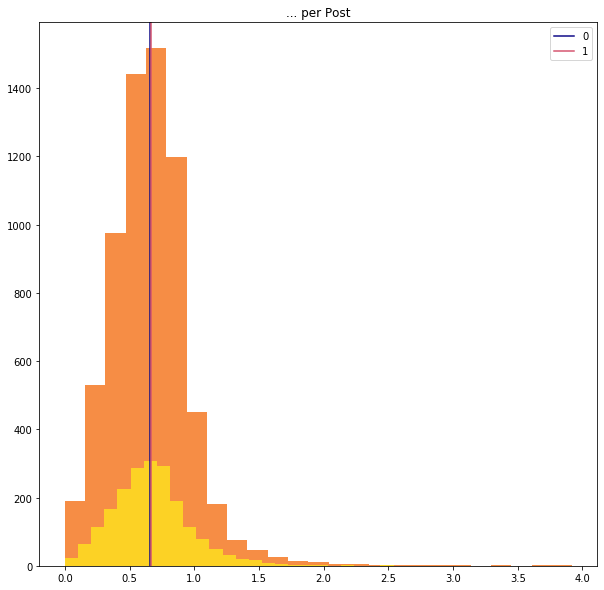

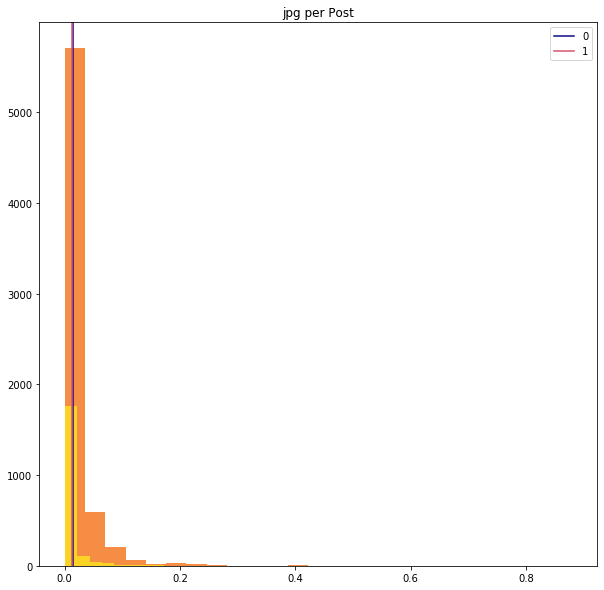

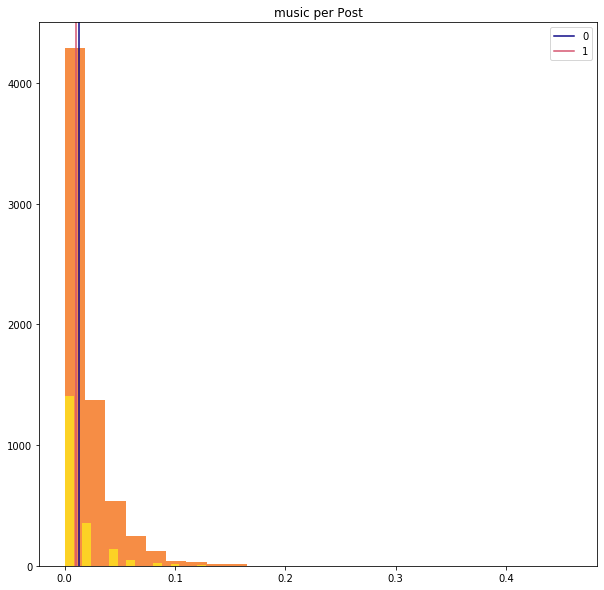

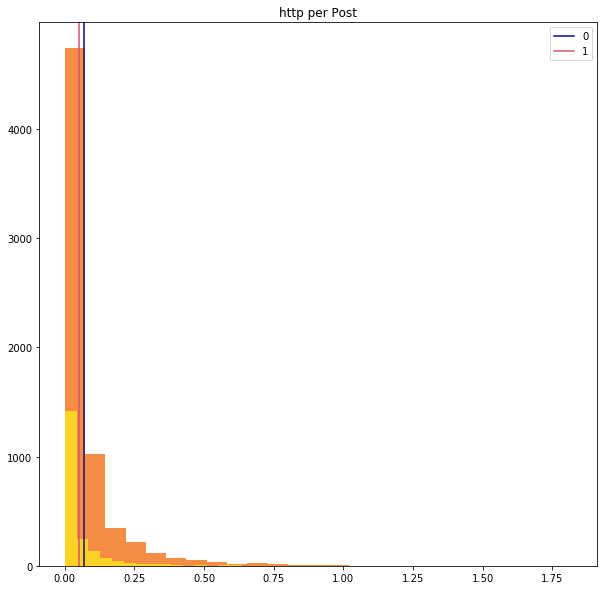

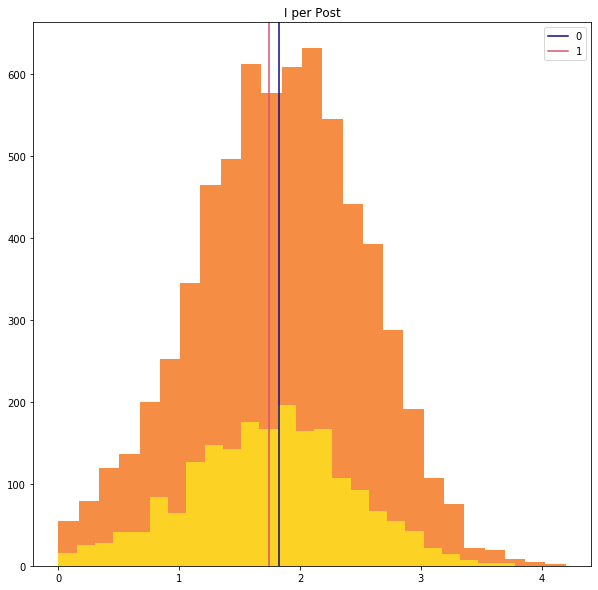

In [26]:
#Wizualizacja Razem --> pokazanie że średnie są niemalże identyczne ==> słaba rozpoznawalność

def wykres_osobowosci_razem_2(od_czego,do_czego='type'):
    from matplotlib import cm
  
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 12))
    colors2 = colors[[8,10],:]
    typ_osobow = np.unique(df[do_czego])
    plt.figure(figsize = (10,10))
   # cmap = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(typ_osobow)):
        if typ_osobow[i] ==0:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[0])
        else:
            plt.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[6])
    
        plt.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors2[i])
        plt.title(od_czego)
        #print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df['type']==typ_osobow[i]])))
    plt.legend(typ_osobow)
    plt.show



wykres_osobowosci_razem_2('words_per_post',do_czego='I-E')
wykres_osobowosci_razem_2('... per Post',do_czego='I-E')
wykres_osobowosci_razem_2('jpg per Post',do_czego='I-E')
wykres_osobowosci_razem_2('music per Post',do_czego='I-E')
wykres_osobowosci_razem_2('http per Post',do_czego='I-E')
wykres_osobowosci_razem_2('I per Post',do_czego='I-E')

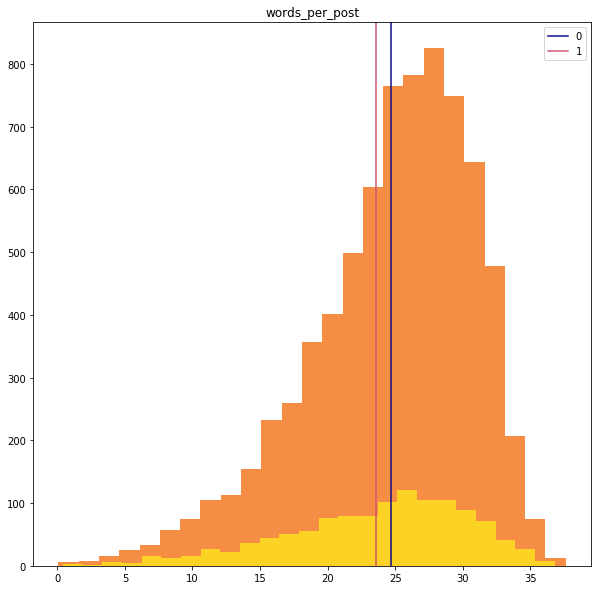

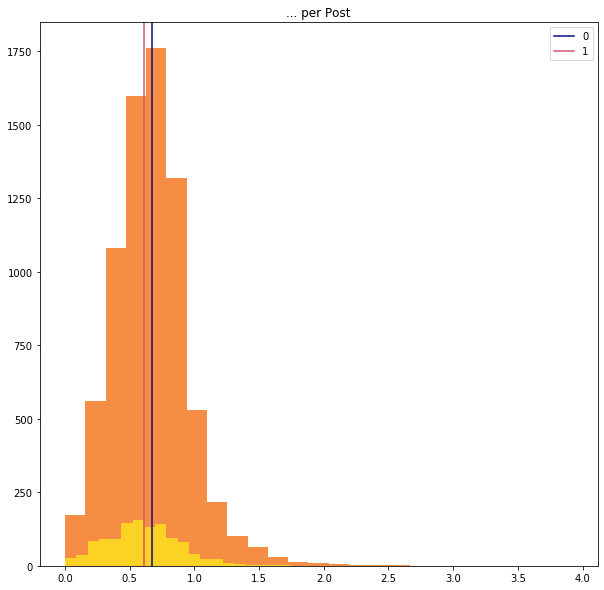

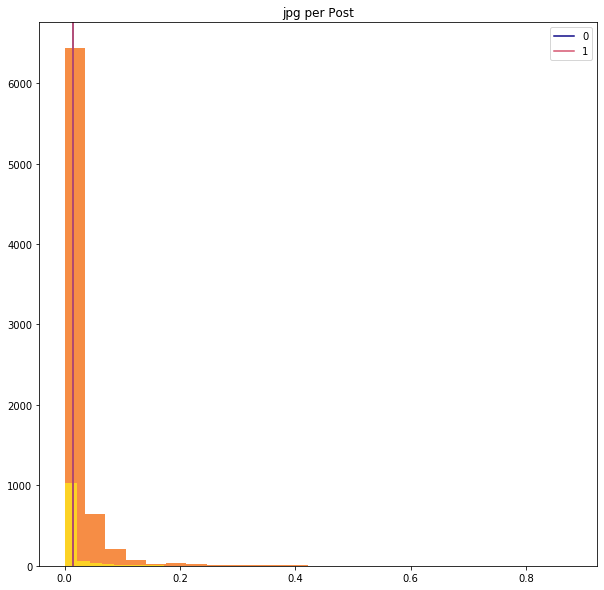

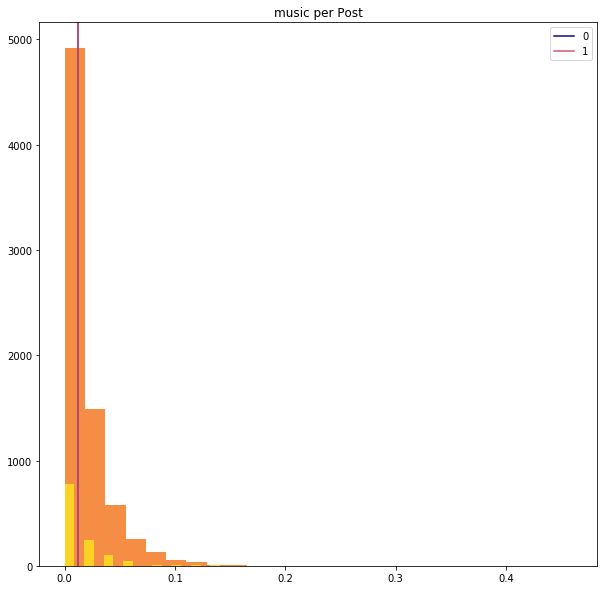

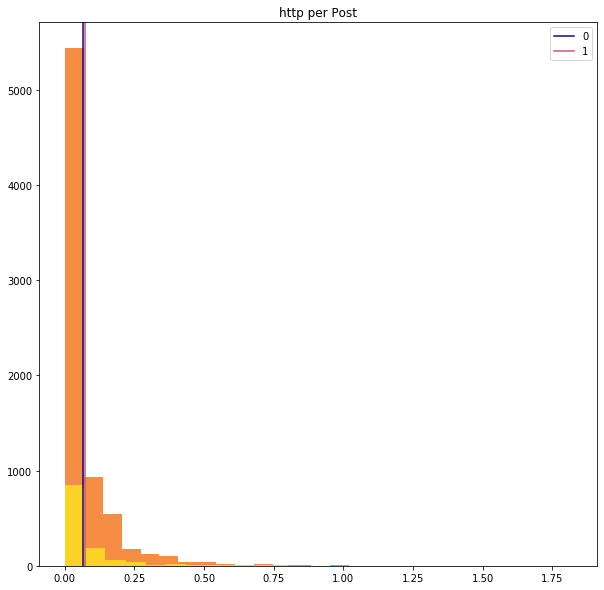

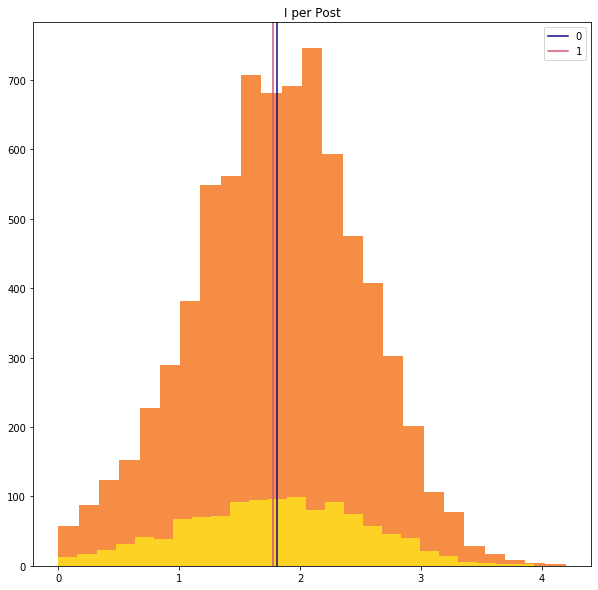

In [27]:
wykres_osobowosci_razem_2('words_per_post',do_czego='N-S')
wykres_osobowosci_razem_2('... per Post',do_czego='N-S')
wykres_osobowosci_razem_2('jpg per Post',do_czego='N-S')
wykres_osobowosci_razem_2('music per Post',do_czego='N-S')
wykres_osobowosci_razem_2('http per Post',do_czego='N-S')
wykres_osobowosci_razem_2('I per Post',do_czego='N-S')

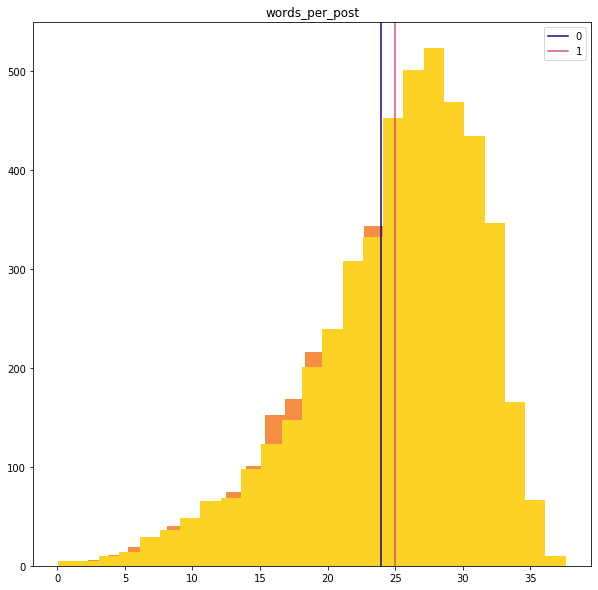

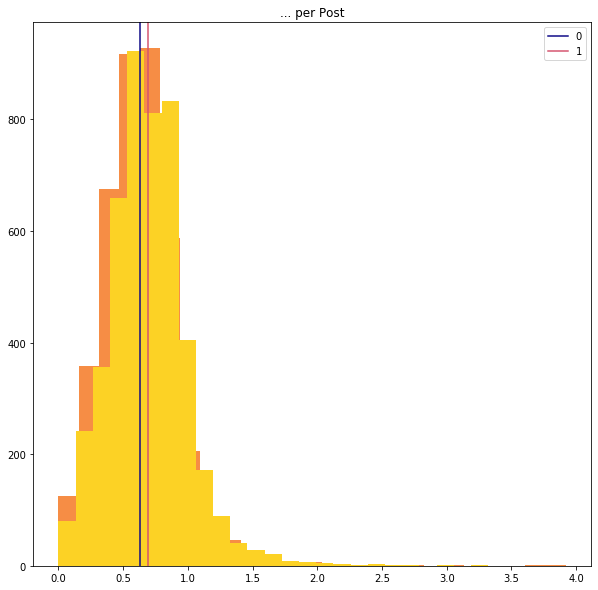

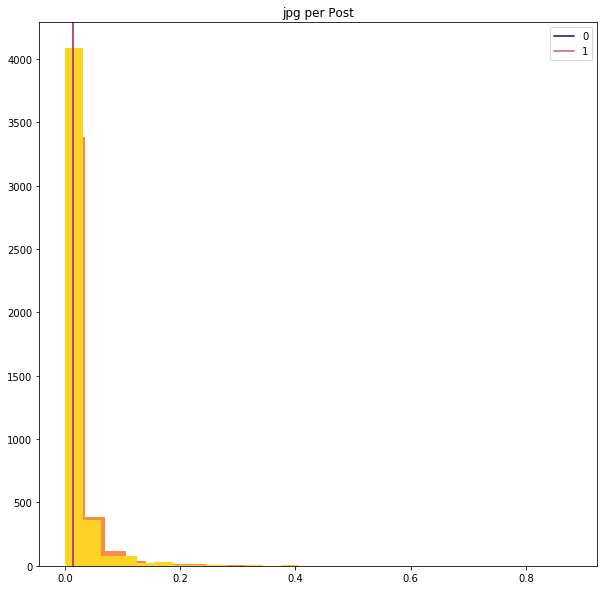

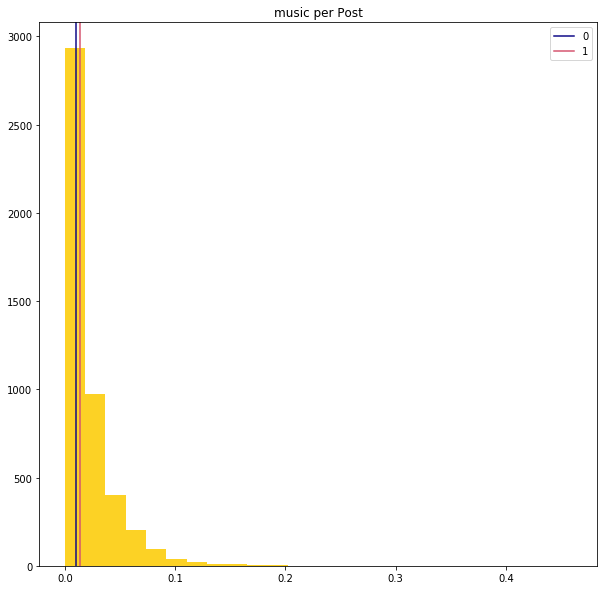

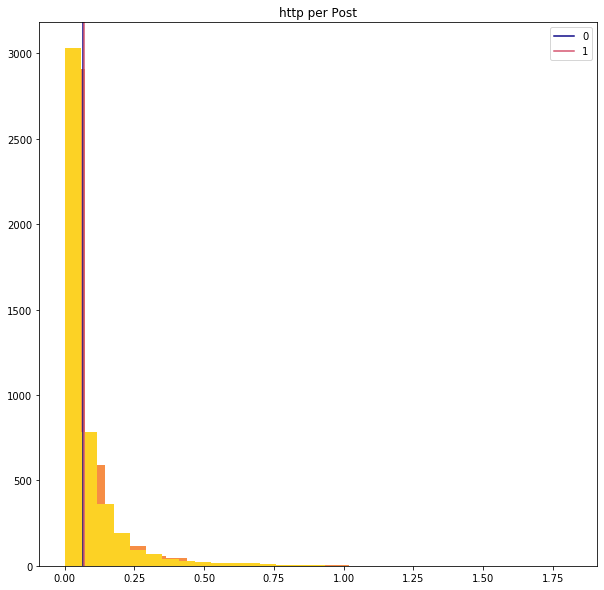

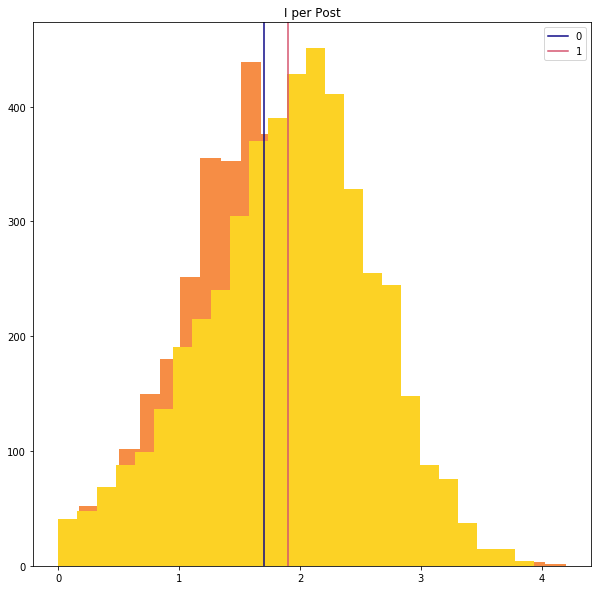

In [28]:
wykres_osobowosci_razem_2('words_per_post',do_czego='T-F')
wykres_osobowosci_razem_2('... per Post',do_czego='T-F')
wykres_osobowosci_razem_2('jpg per Post',do_czego='T-F')
wykres_osobowosci_razem_2('music per Post',do_czego='T-F')
wykres_osobowosci_razem_2('http per Post',do_czego='T-F')
wykres_osobowosci_razem_2('I per Post',do_czego='T-F')

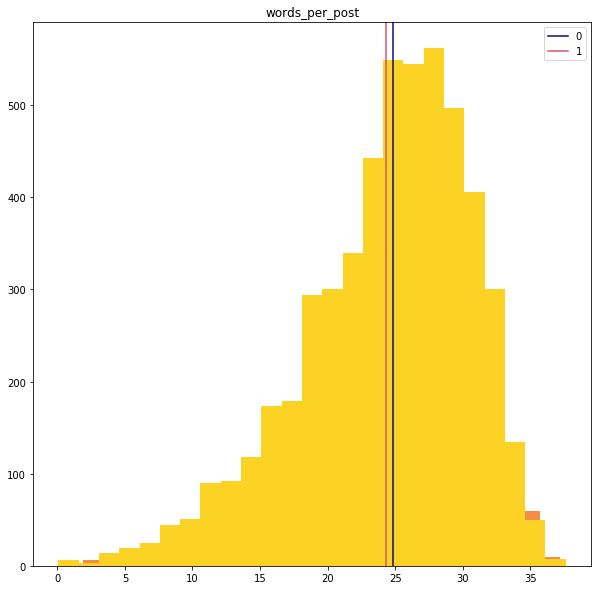

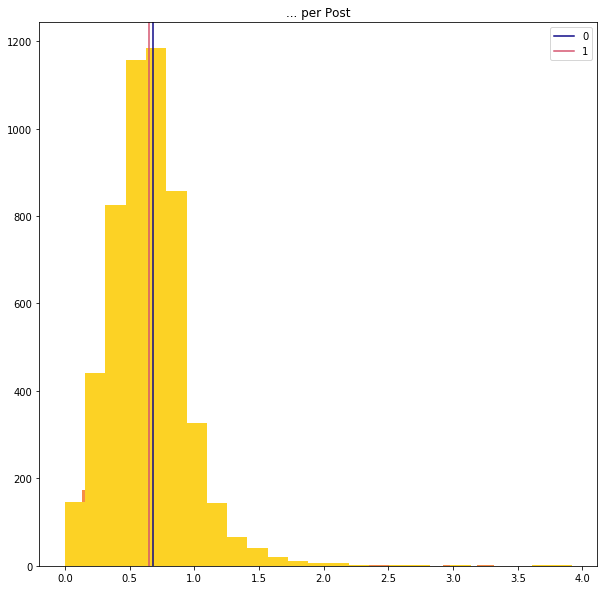

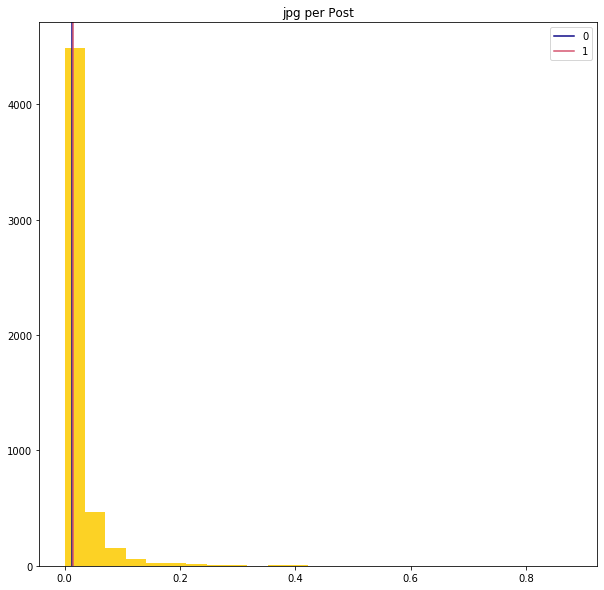

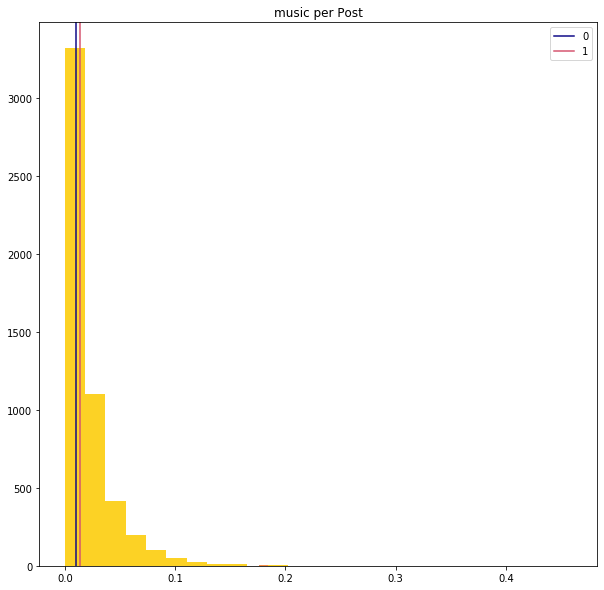

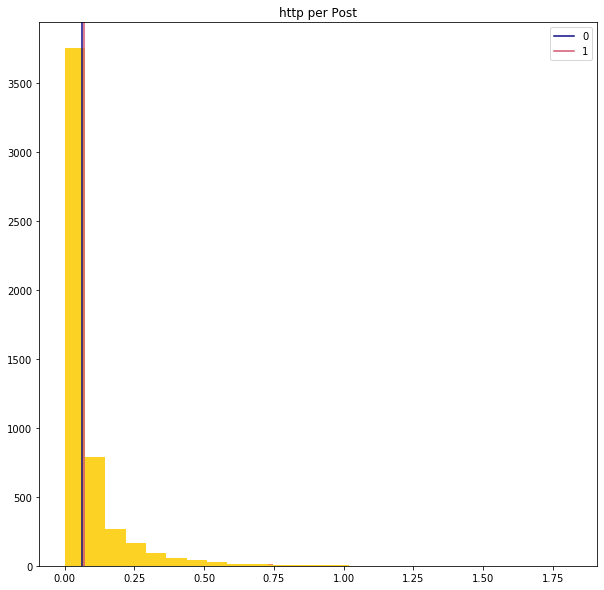

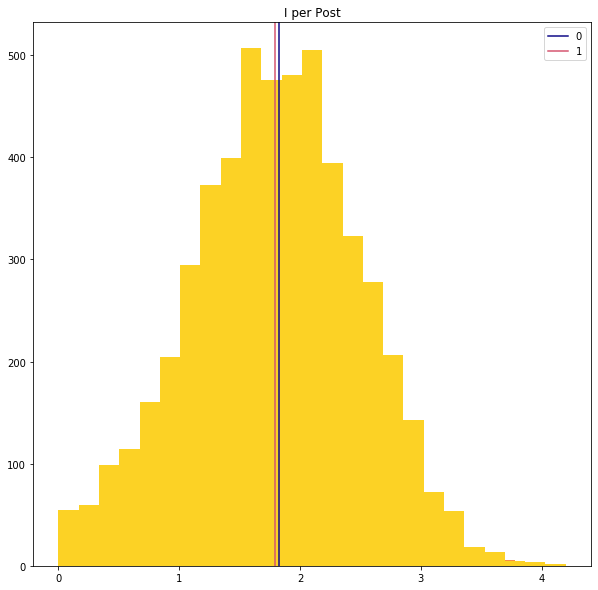

In [29]:
wykres_osobowosci_razem_2('words_per_post',do_czego='J-P')
wykres_osobowosci_razem_2('... per Post',do_czego='J-P')
wykres_osobowosci_razem_2('jpg per Post',do_czego='J-P')
wykres_osobowosci_razem_2('music per Post',do_czego='J-P')
wykres_osobowosci_razem_2('http per Post',do_czego='J-P')
wykres_osobowosci_razem_2('I per Post',do_czego='J-P')

I-E
0: 24.50591372079095
1: 24.588854427213555
N-S
0: 24.679096014977333
1: 23.56250626566416
T-F
0: 23.94178849535291
1: 25.019671921602065
J-P
0: 24.841927781013478
1: 24.317385995039103


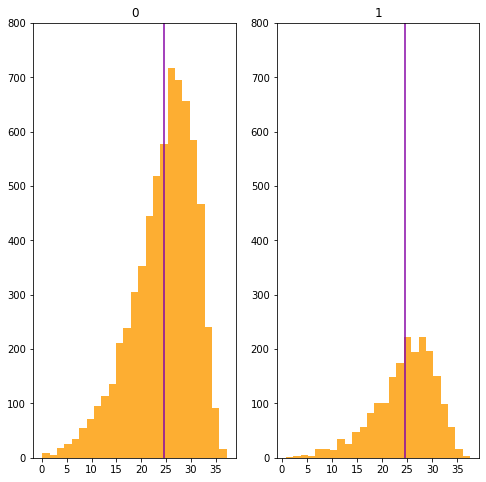

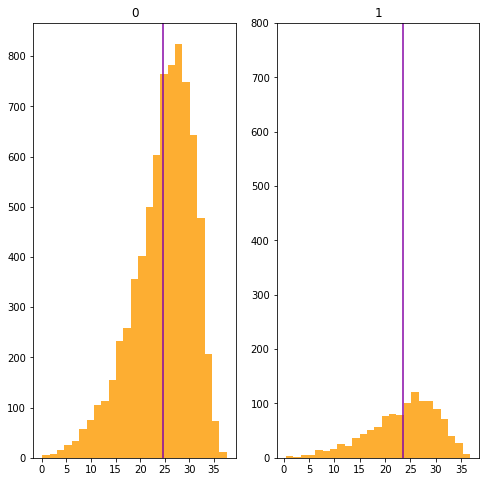

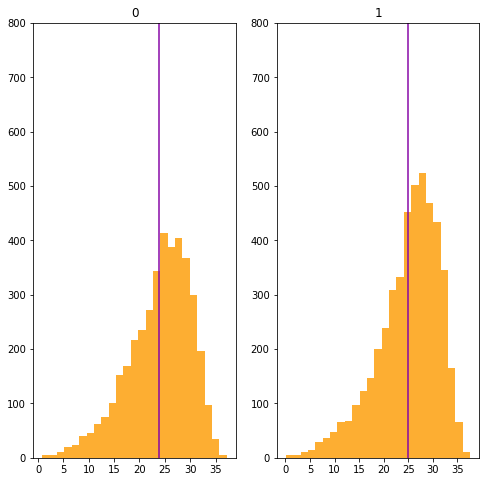

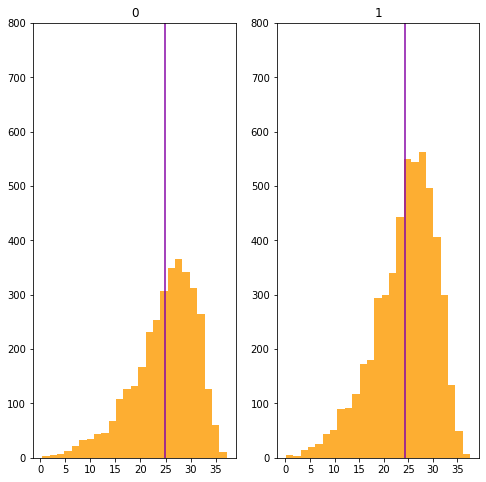

In [30]:
def wykres_osobowosci_rozdzielon(od_czego,do_czego,ticks=(0,5,10,15,20,25,30,35),yticks = [0,100,200,300,400,500,600,700,800]):
    from matplotlib import cm
    viridis = cm.get_cmap('plasma', 12)
    colors = viridis(np.linspace(0, 1, 16))
    typ_osobow = np.unique(df[do_czego])
    print(do_czego)
    fig,axes = plt.subplots(1,2,figsize=(8,8))
    for i,ax in zip(range(len(typ_osobow)),axes.ravel()):
        ax.hist(df[od_czego].loc[df[do_czego]==typ_osobow[i]],bins=25,color=colors[12])
        ax.axvline(x=np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]]),color=colors[4])
        ax.set_xticks(ticks)
        ax.set_yticks(yticks)

        ax.title.set_text(typ_osobow[i])
        print("{}: {}".format(typ_osobow[i],np.mean(df[od_czego].loc[df[do_czego]==typ_osobow[i]])))
    plt.show

warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('words_per_post',j)

I-E
0: 0.07072798082684274
1: 0.0505952976488245
N-S
0: 0.06501738432736055
1: 0.07278195488721813
T-F
0: 0.06396885204722495
1: 0.06788666382616158
J-P
0: 0.0629237041351199
1: 0.06816256439610789


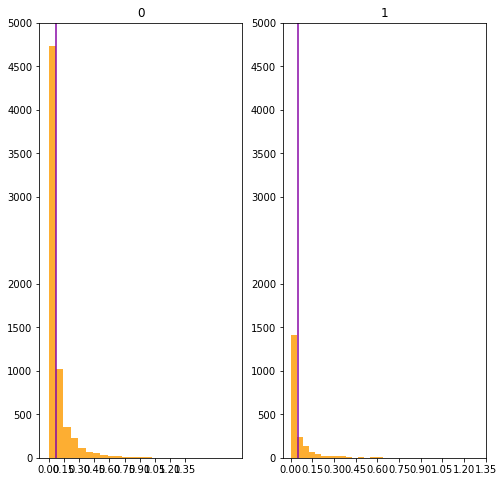

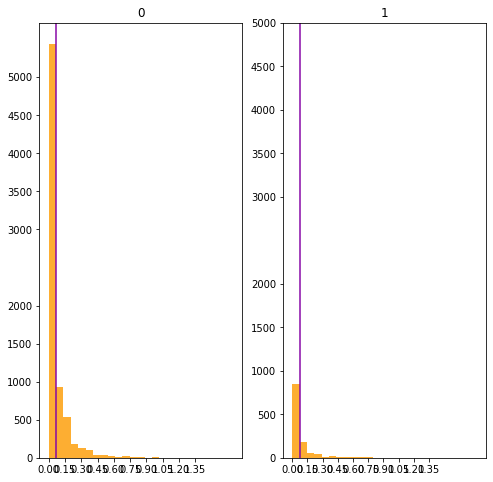

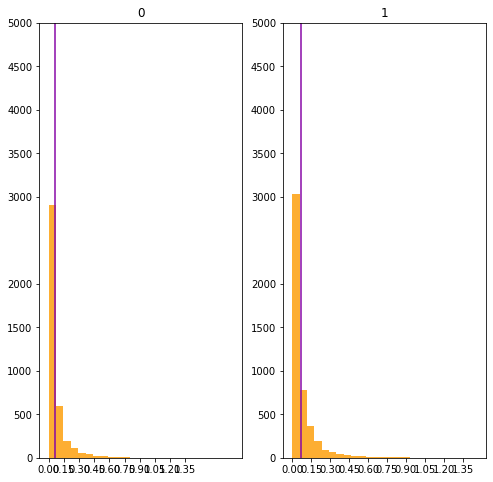

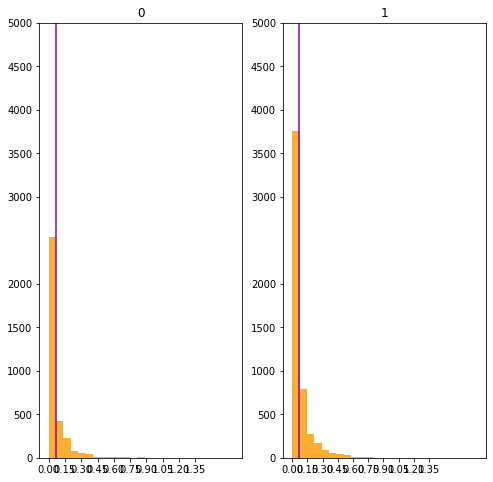

In [31]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('http per Post',j,ticks = [0,0.15,0.3,0.45,0.6,0.75,0.9,1.05,1.2,1.35],yticks = (0,500,1000,1500,2000,3000,3500,4000,4500,5000))

I-E
0: 0.6609227082085082
1: 0.6677038519259654
N-S
0: 0.6711152714629581
1: 0.6085714285714282
T-F
0: 0.6276262245666917
1: 0.6920494247976133
J-P
0: 0.678893418753641
1: 0.6517344018317107


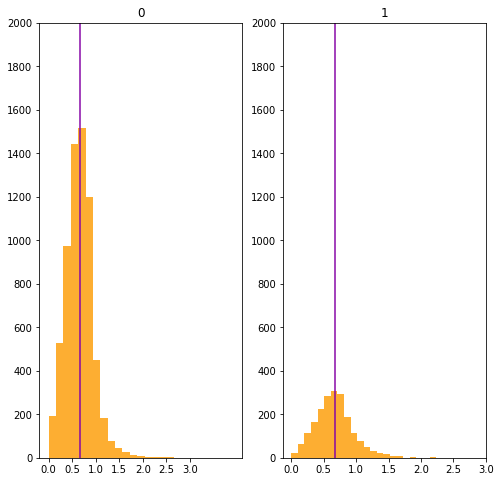

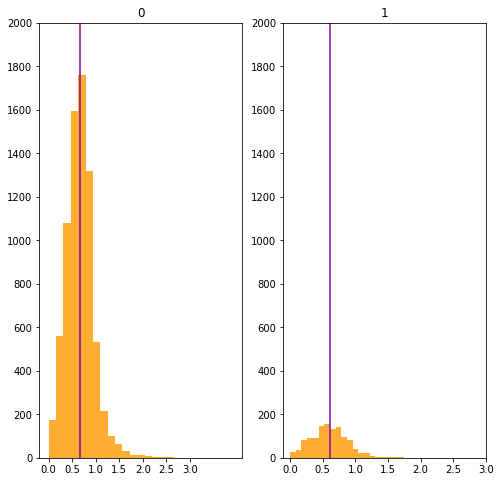

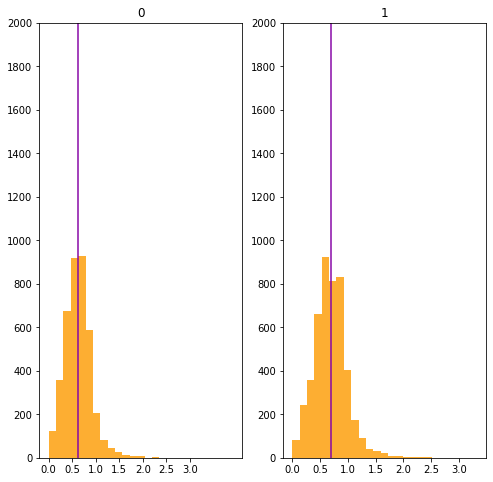

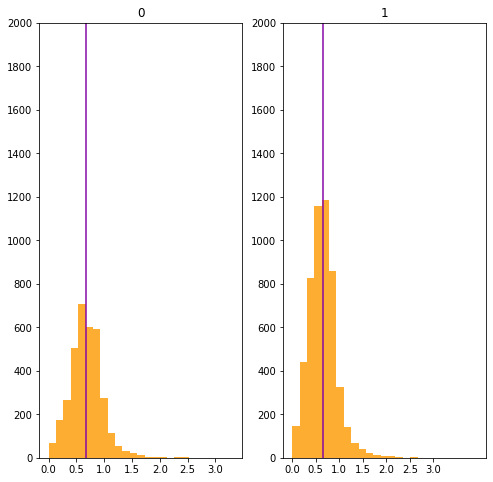

In [32]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('... per Post',j,ticks=(0.0,0.5,1.0,1.5,2.0,2.5,3.0), yticks = [0,200,400,600,800,1000,1200,1400,1600,1800,2000])

I-E
0: 0.013040742959856327
1: 0.010075037518759277
N-S
0: 0.012377641080502889
1: 0.012230576441102665
T-F
0: 0.010158251695553878
1: 0.0142224115892631
J-P
0: 0.010302853814793162
1: 0.013703491700057394


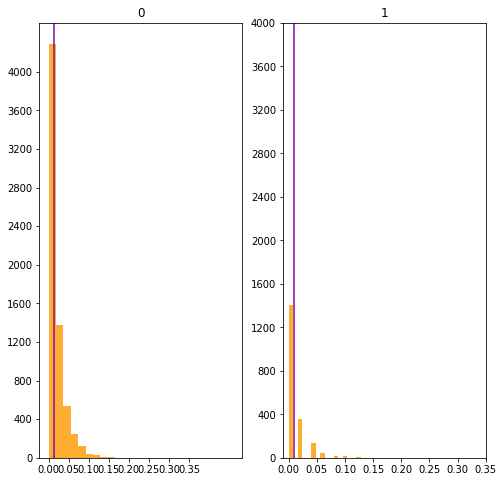

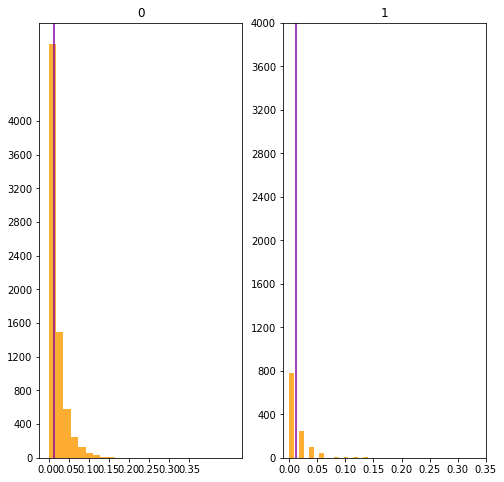

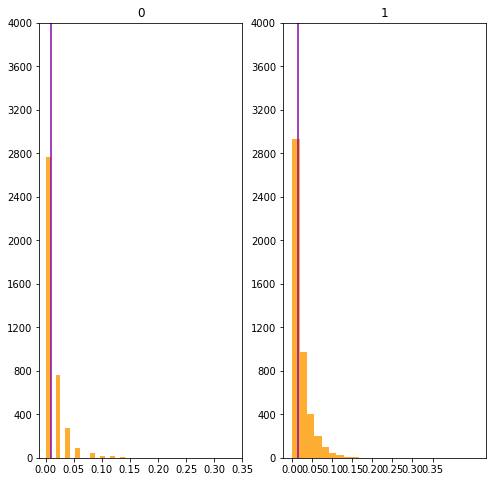

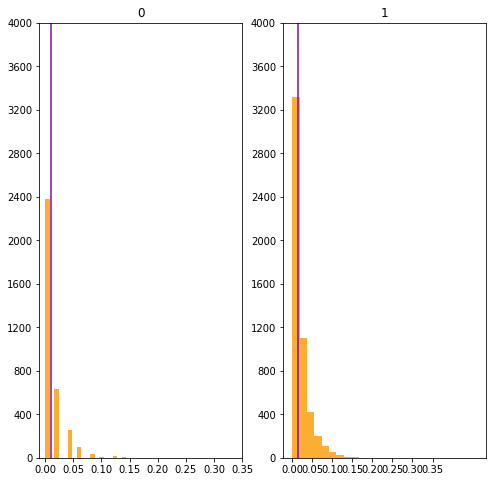

In [33]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('music per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35),yticks = [0,400,800,1200,1600,2000,2400,2800,3200,3600,4000])

I-E
0: 0.014562612342720268
1: 0.011985992996498166
N-S
0: 0.013976999197646492
1: 0.013918128654970692
T-F
0: 0.014508917357447977
1: 0.013510864933958358
J-P
0: 0.013261502620850348
1: 0.014432360236596168


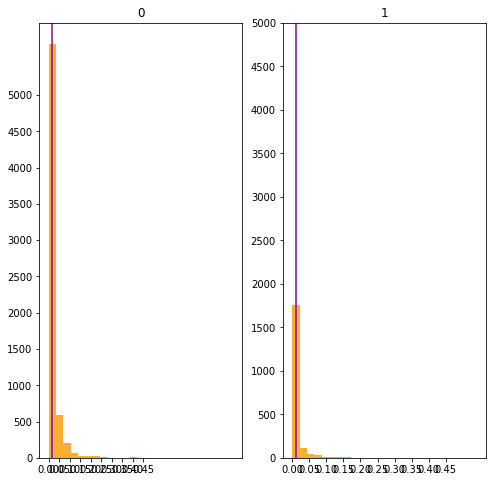

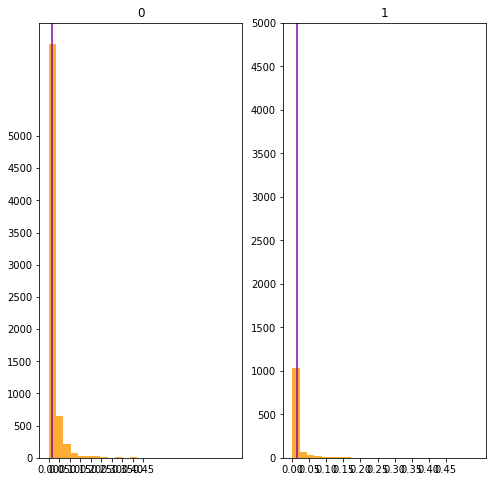

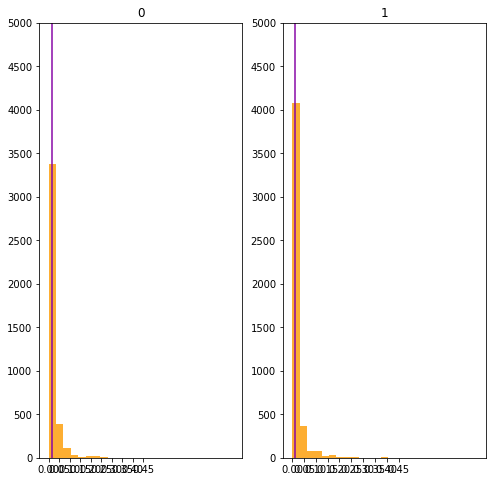

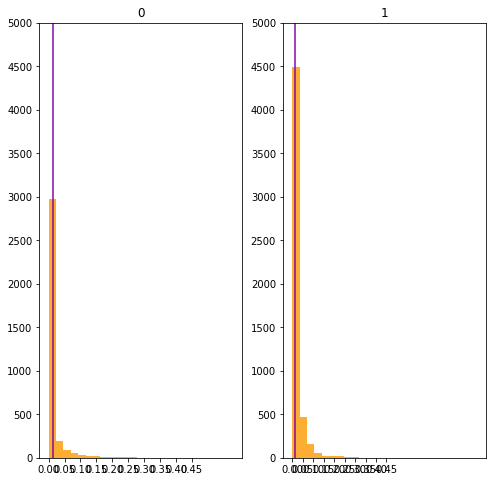

In [34]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('jpg per Post',j,ticks=(0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45),yticks = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000])

I-E
0: 1.8272019173157534
1: 1.7394697348674293
N-S
0: 1.811963091735753
1: 1.7758897243107783
T-F
0: 1.700648078372273
1: 1.8971708564124379
J-P
0: 1.8292195690157196
1: 1.7924174775806108


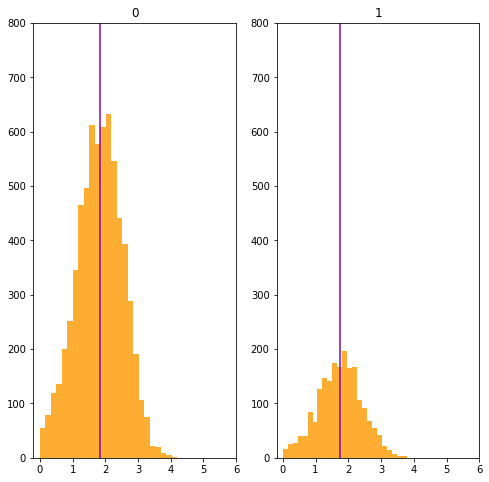

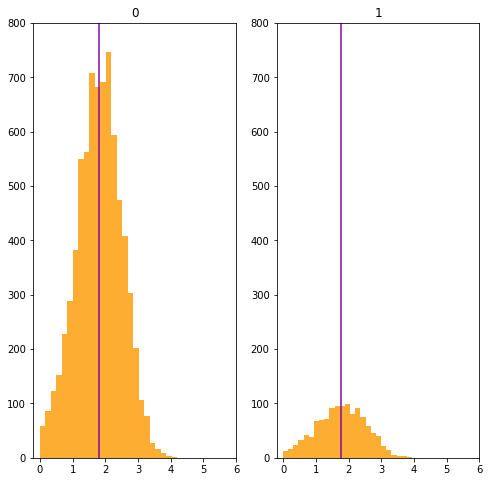

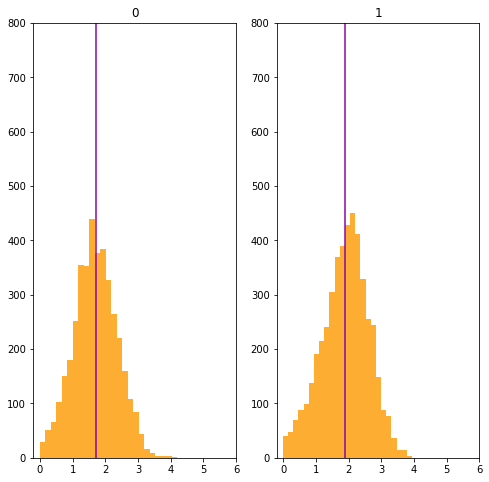

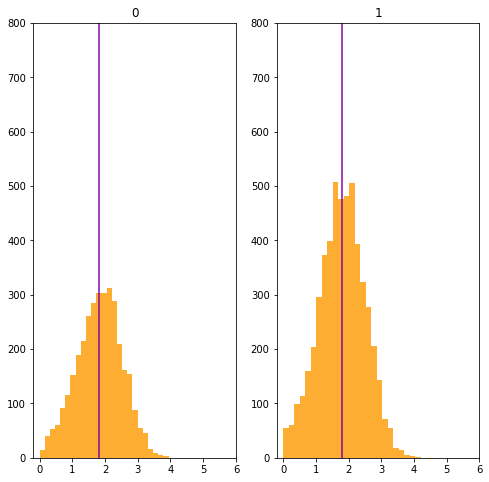

In [35]:
warunki_osobow = ['I-E','N-S','T-F','J-P']        
for j in warunki_osobow:
    wykres_osobowosci_rozdzielon('I per Post',j,ticks=(0.0,1,2,3,4,5,6))

Zobaczmy jeszcze jak wygląda ilość słów w poszczególnych grupach

I-E


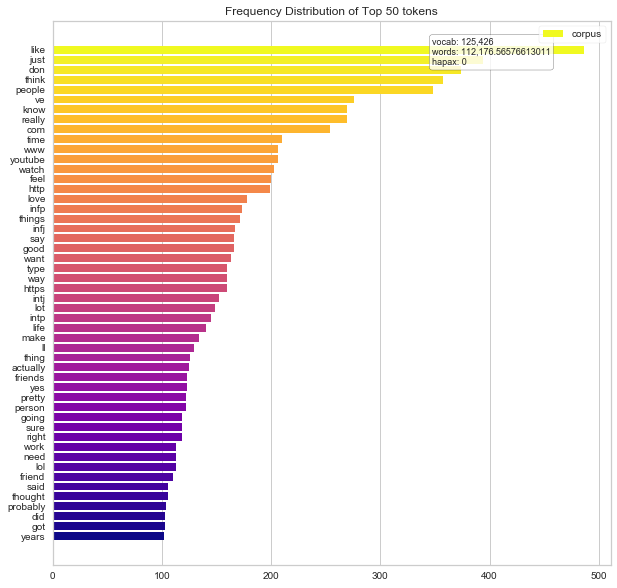

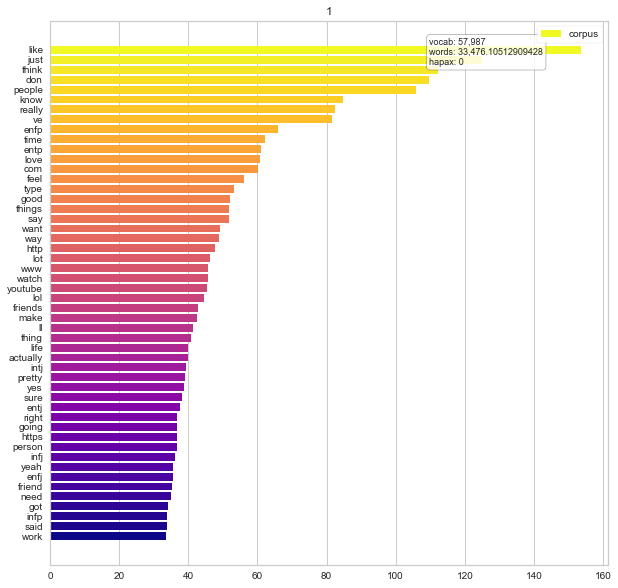

N-S


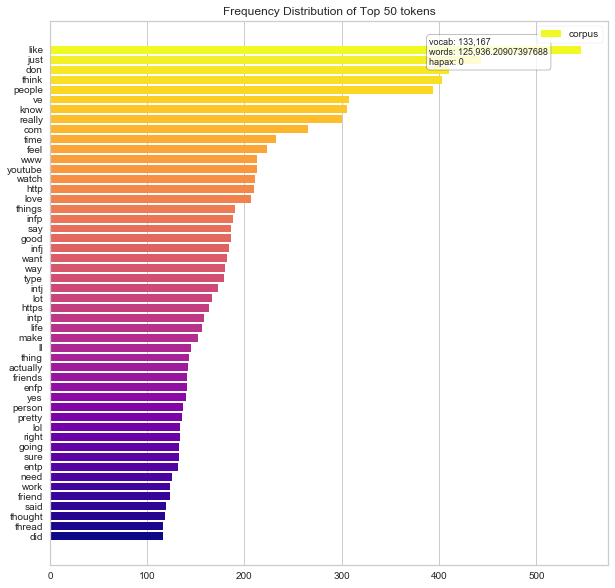

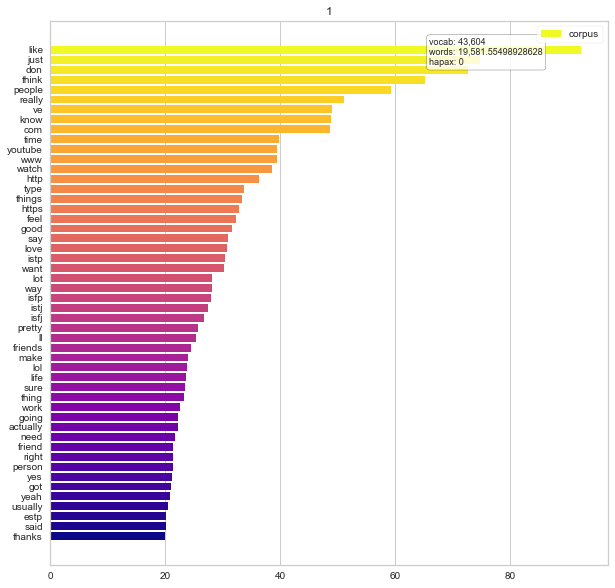

T-F


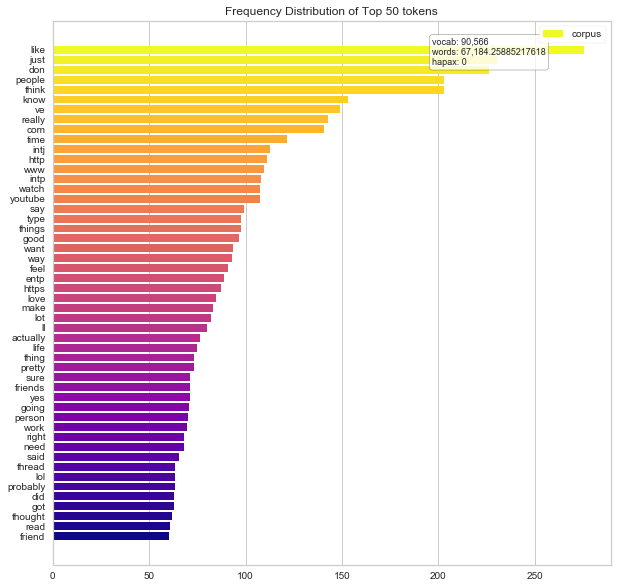

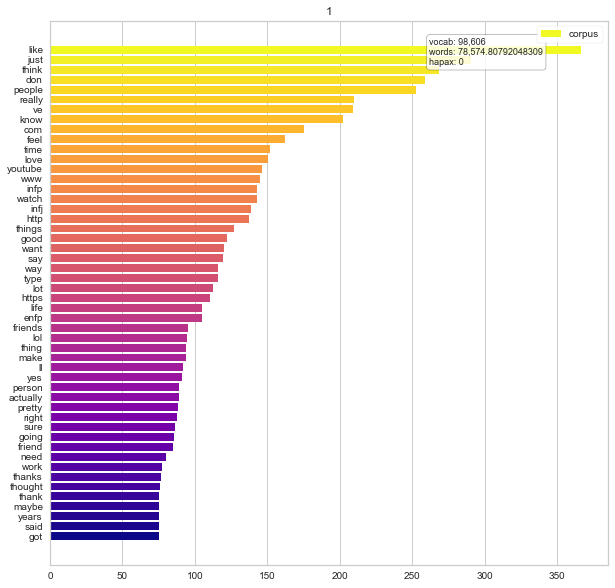

J-P


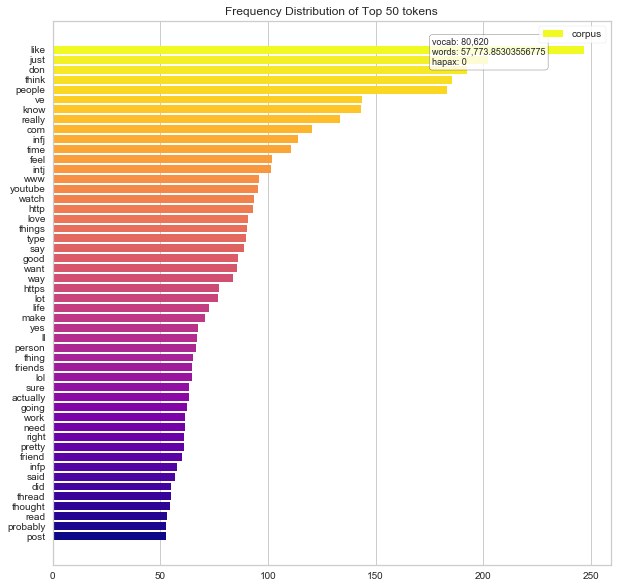

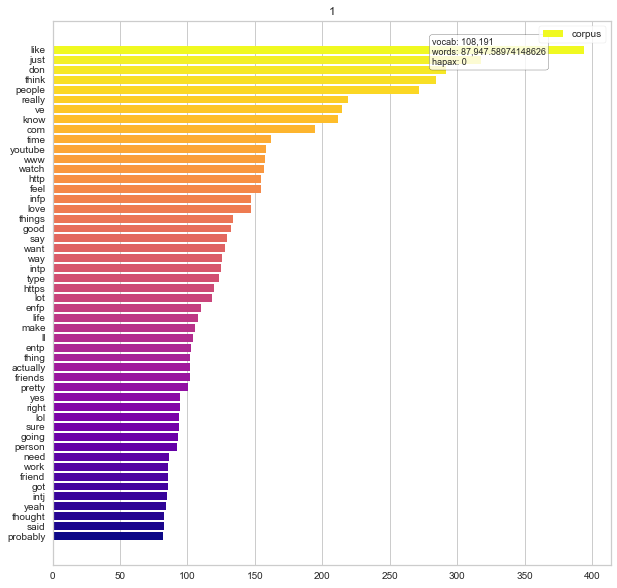

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

def Most_frequent_words_in_Group(types,pyte='type'):
    XXX = df['posts'].loc[df[pyte] == types].values

    from matplotlib import cm

    cnt_srs = df['type'].value_counts()
    viridis = cm.get_cmap('plasma', 50)
    colors = viridis(np.flip(np.linspace(0, 1, 50)))
    
    
    TfidVect  = tfidf.fit_transform(XXX)
    svd_model = tsvd
    data_revitalised = svd_model.fit_transform(TfidVect)
    plt.figure(figsize = (10,10))
    visualizer = FreqDistVisualizer(features=tfidf.get_feature_names(), orient='h',title =types, color = colors)
    visualizer.fit(TfidVect)
    #visualizer.title(types)
    visualizer.show()
    
    
print('I-E')    
Most_frequent_words_in_Group(0,pyte = 'I-E')
Most_frequent_words_in_Group(1,'I-E')
print('N-S')  
Most_frequent_words_in_Group(0,'N-S')
Most_frequent_words_in_Group(1,'N-S')
print('T-F')  
Most_frequent_words_in_Group(0,'T-F')
Most_frequent_words_in_Group(1,'T-F')
print('J-P')  
Most_frequent_words_in_Group(0,'J-P')
Most_frequent_words_in_Group(1,'J-P')

**PCA - okazało się zbędne** -- Przeprowdzono również PCA dla każdego z modeli, niestety rezultaty okazały się gorsze

### Klasyfikacja I-E 

In [73]:
#Czyścimy zbiór Danych z  niepotrzebnych linków itp.

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)


In [93]:
XX = df['clean_posts'].values
yy = df['I-E'].values

print(XX.shape)
print(yy.shape)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

#Przeprowadzamy Text Mining oraz Skalowanie danych i redukcje wymiarów

tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)

TfidVect  = tfidf.fit_transform(X_train)
svd_model = tsvd
data_revitalised = svd_model.fit_transform(TfidVect)

TfidVect_test  = tfidf.fit_transform(X_test)
svd_model_test = tsvd
data_revitalised_test = svd_model_test.fit_transform(TfidVect_test)


from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_res_aut, y_train_res_aut = sm.fit_sample(data_revitalised, y_train)


(8675,)
(8675,)


#####  Klasyfikator 1 --> SVC

In [94]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

svmIE = SVC(kernel = 'rbf', C = 1, gamma = 100,probability = True)
svmIE.fit(X_train_res_aut,y_train_res_aut)




SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

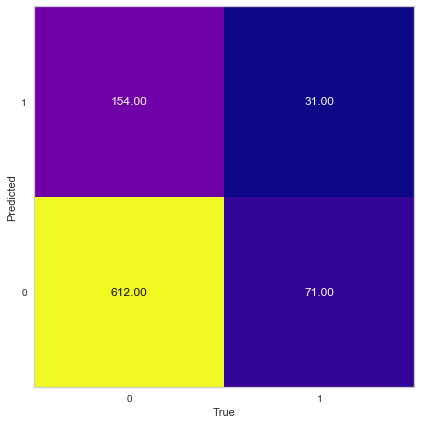

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics


array =metrics.confusion_matrix(y_test, svmIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [96]:
from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmIE.predict(data_revitalised_test)) ))

R^2: 0.5514385911022373
precision: 0.5318072098452772
recall_score: 0.5318072098452772
f1_score: 0.530374185729435
accuracy_score: 0.7407834101382489


Average precision-recall score: 0.29


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.29')

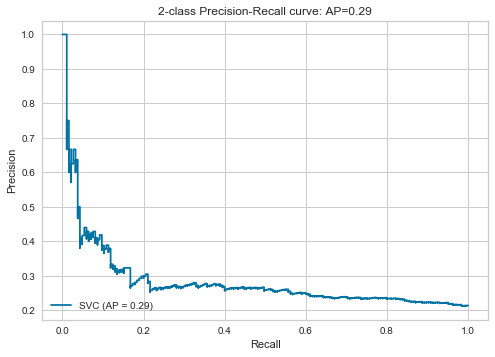

In [97]:
y_score = svmIE.decision_function(data_revitalised_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmIE, data_revitalised_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 2 --> Extra Trees Classifier

In [98]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDIE = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDIE.fit(X_train_res_aut,y_train_res_aut)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=64, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

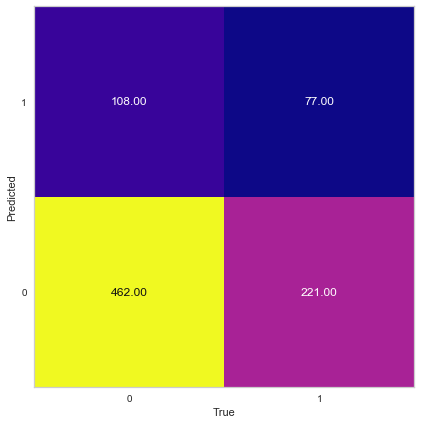

In [99]:
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDIE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [100]:
from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDIE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDIE.predict(data_revitalised_test)) ))

R^2: 0.53445778876722
precision: 0.5463218709192355
recall_score: 0.5463218709192355
f1_score: 0.5281353736539551
accuracy_score: 0.6209677419354839


#####  Klasyfikator 3 (Najlepszy) --> Voting Obu

In [101]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_IE = VotingClassifier(
    estimators=[('lr', svmIE), ('svc', RNDIE)], voting='soft')
voting_clf_IE.fit(X_train_res_aut, y_train_res_aut)

VotingClassifier(estimators=[('lr',
                              SVC(C=1, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=64,
            

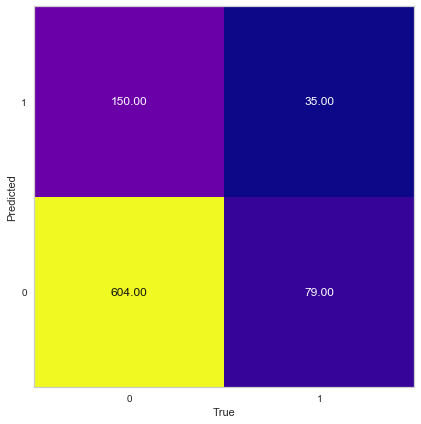

In [102]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf_IE.predict(data_revitalised_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [103]:
print("R^2: {}".format(metrics.precision_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf_IE.predict(data_revitalised_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf_IE.predict(data_revitalised_test)) ))

R^2: 0.5540392759086044
precision: 0.5367615052827351
recall_score: 0.5367615052827351
f1_score: 0.5373769675303668
accuracy_score: 0.7361751152073732


### Klasyfikacja N-S z Resamplingiem

In [104]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['N-S'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> SVC

In [116]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

svmNS2 = SVC(kernel = 'rbf', C =10, gamma = 100,probability = True)
svmNS2.fit(X_train_res,y_train_res)


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

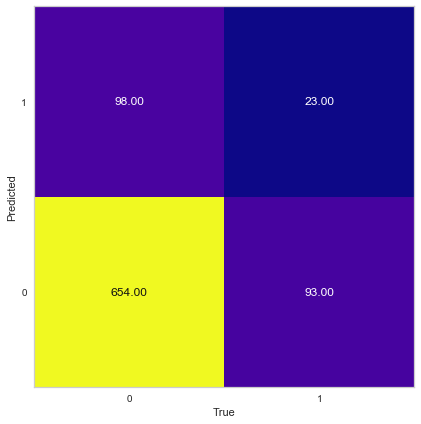

In [117]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, svmNS2.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [118]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, svmNS2.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, svmNS2.predict(X_test)) ))

R^2: 0.5339783565663976
precision: 0.5327923263301139
recall_score: 0.5327923263301139
f1_score: 0.5333372740758255
accuracy_score: 0.7799539170506913


Average precision-recall score: 0.16


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.16')

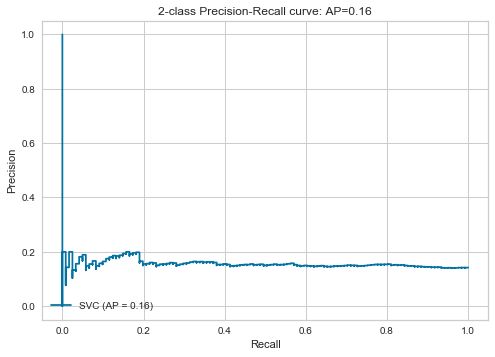

In [119]:
y_score = svmNS2.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmNS2, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 2--> Extra Trees Classifier

In [111]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDNS = ExtraTreesClassifier(max_leaf_nodes = 64, n_estimators =1000)
RNDNS.fit(X_train_res,y_train_res)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=64, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

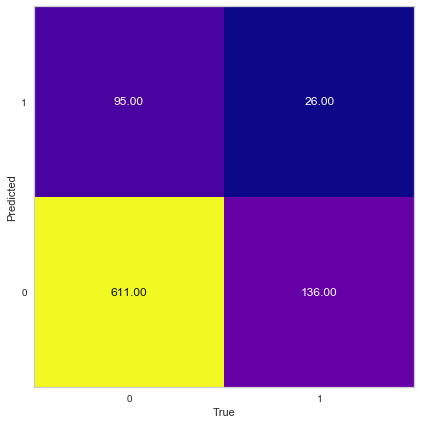

In [112]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, RNDNS.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [113]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, RNDNS.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, RNDNS.predict(X_test)) ))

R^2: 0.5129664603224565
precision: 0.516407226702955
recall_score: 0.516407226702955
f1_score: 0.5123820826412516
accuracy_score: 0.7338709677419355


#####  Klasyfikator 3 (Najlepszy) --> Voting

In [120]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf = VotingClassifier(
    estimators=[('lr', svmNS2), ('svc', RNDNS)], voting='soft')
voting_clf.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=10, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=64,
           

In [121]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test, voting_clf.predict(X_test),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test, voting_clf.predict(X_test)) ))

R^2: 0.5214081690945445
precision: 0.5165842433093255
recall_score: 0.5165842433093255
f1_score: 0.517140859296092
accuracy_score: 0.793778801843318


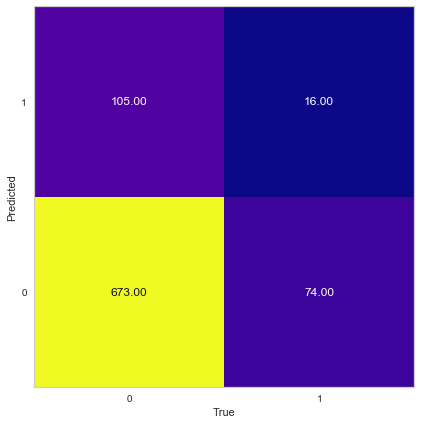

In [122]:

from sklearn import metrics

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test, voting_clf.predict(X_test))

personality_types = np.unique(y_test)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Klasyfikacja T-F z Resamplingiem

In [48]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['T-F'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> Regresja Logistyczna

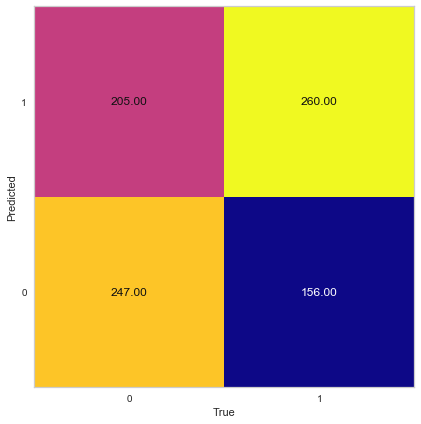

In [125]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

LogRegTF2 = LogisticRegression(penalty = 'l2', C =100)
LogRegTF2.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegTF2.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [126]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegTF2.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegTF2.predict(X_test_norm)) ))

R^2: 0.5857300884955752
precision: 0.586021505376344
recall_score: 0.586021505376344
f1_score: 0.5840080716357674
accuracy_score: 0.5841013824884793


#####  Klasyfikator 2 --> SVC

In [54]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

svmTF = SVC(kernel = 'rbf', C =1000, gamma = 0.1,probability = True)
svmTF.fit(X_train_res,y_train_res)



SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

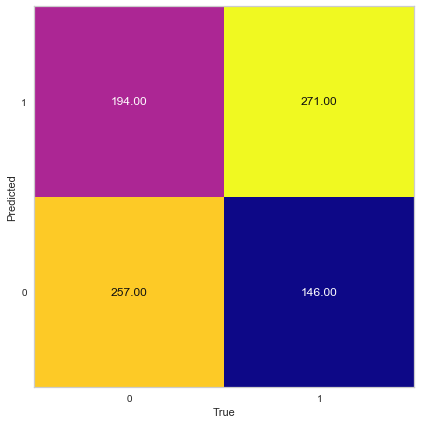

In [56]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

array =metrics.confusion_matrix(y_test_norm, svmTF.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [57]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmTF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmTF.predict(X_test_norm)) ))

R^2: 0.6098624426401229
precision: 0.6102564102564103
recall_score: 0.6102564102564103
f1_score: 0.6081930039775474
accuracy_score: 0.6082949308755761


Average precision-recall score: 0.65


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.65')

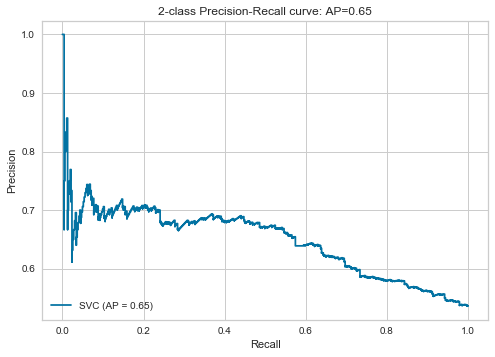

In [58]:
y_score = svmTF.decision_function(X_test_norm)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_norm, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmTF, X_test_norm, y_test_norm)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 3 (najlepszy) --> Voting

In [129]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_TF = VotingClassifier(
    estimators=[('lr', svmTF), ('svc', LogRegTF2)], voting='soft')
voting_clf_TF.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=1000, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.1, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                          

In [130]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_TF.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_TF.predict(X_test_norm)) ))

R^2: 0.6079716893276215
precision: 0.6082712985938792
recall_score: 0.6082712985938792
f1_score: 0.6059384806537427
accuracy_score: 0.6059907834101382


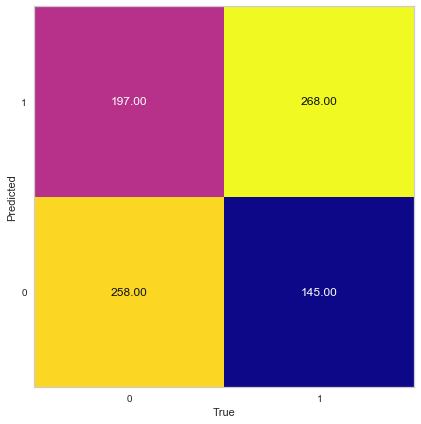

In [131]:

from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, voting_clf_TF.predict(X_test))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show() 

### Klasyfikacja J-P z Resamplingiem

In [59]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2


XX = df.drop(['type','posts','I-E','N-S','T-F','J-P','clean_posts'], axis=1).values
yy = df['J-P'].values

from sklearn.model_selection import train_test_split
X_train,X_test_norm,y_train,y_test_norm=train_test_split(XX,yy,test_size = 0.1, random_state=42)

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#####  Klasyfikator 1 --> Extra Trees Classifier

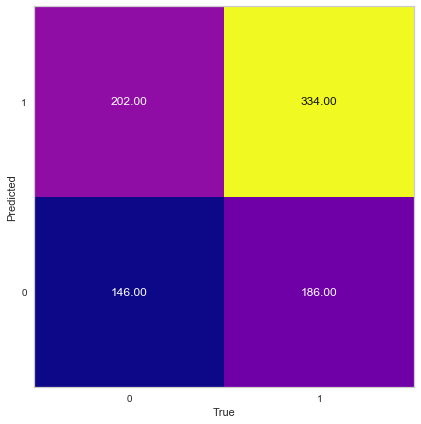

In [60]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

RNDJP = ExtraTreesClassifier(max_leaf_nodes = 128, n_estimators =1000)
RNDJP.fit(X_train_res,y_train_res)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, RNDJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [61]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, RNDJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, RNDJP.predict(X_test_norm)) ))

R^2: 0.530923961096375
precision: 0.5314466822513936
recall_score: 0.5314466822513936
f1_score: 0.53099376114082
accuracy_score: 0.5529953917050692


#####  Klasyfikator 2 --> Regresja Logistyczna

0.5230414746543779


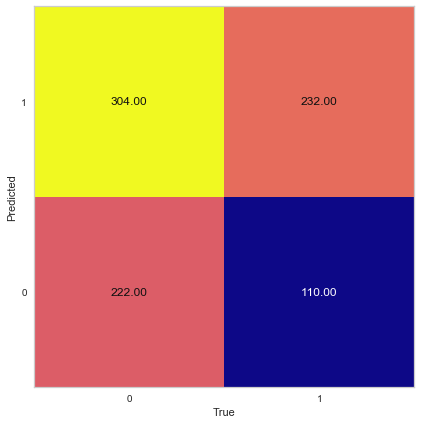

In [62]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

LogRegJP = LogisticRegression(penalty = 'l2', C =100)
LogRegJP.fit(X_train_res,y_train_res)
print(metrics.accuracy_score(y_test_norm,LogRegJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, LogRegJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()


In [63]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, LogRegJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, LogRegJP.predict(X_test_norm)) ))

R^2: 0.5502079025192893
precision: 0.5507552598453516
recall_score: 0.5507552598453516
f1_score: 0.5229781607913726
accuracy_score: 0.5230414746543779


#####  Klasyfikator 3 --> SVC

0.5633640552995391


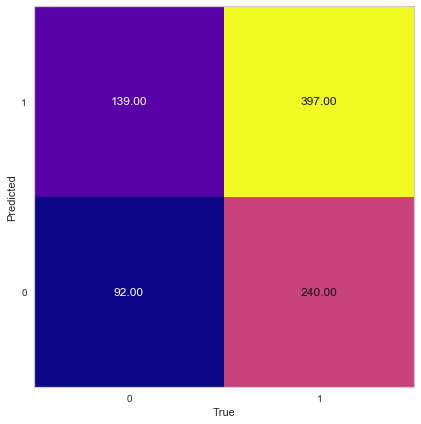

In [64]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics        
svmJP = SVC(kernel = 'rbf', C =1, gamma =100,probability = True)
svmJP.fit(X_train_res,y_train_res)

print(metrics.accuracy_score(y_test_norm,svmJP.predict(X_test_norm)))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =metrics.confusion_matrix(y_test_norm, svmJP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()

In [65]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, svmJP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, svmJP.predict(X_test_norm)) ))

R^2: 0.5107511536082965
precision: 0.5088900377629922
recall_score: 0.5088900377629922
f1_score: 0.5018587248012186
accuracy_score: 0.5633640552995391


Average precision-recall score: 0.60


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.60')

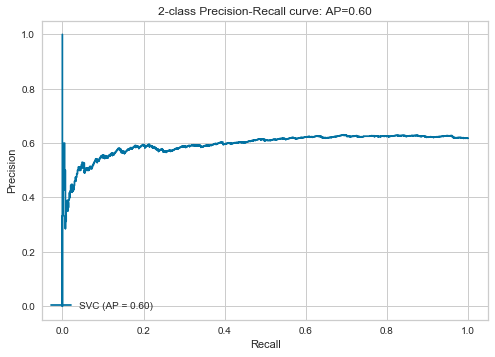

In [66]:
y_score = svmJP.decision_function(X_test_norm)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_norm, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svmJP, X_test_norm, y_test_norm)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#####  Klasyfikator 4 (Najlepszy) --> Voting

In [67]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

voting_clf_JP = VotingClassifier(
    estimators=[('lr', svmJP), ('svc', LogRegJP),('rnd', RNDJP)], voting='soft')
voting_clf_JP.fit(X_train_res, y_train_res)



VotingClassifier(estimators=[('lr',
                              SVC(C=1, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=100, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('svc',
                              LogisticRegression(C=100, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling...
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_

In [68]:

from sklearn import metrics

print("R^2: {}".format(metrics.precision_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("precision: {}".format(metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("recall_score: {}".format( metrics.recall_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("f1_score: {}".format( metrics.f1_score(y_test_norm, voting_clf_JP.predict(X_test_norm),average='macro') ))
print("accuracy_score: {}".format( metrics.accuracy_score(y_test_norm, voting_clf_JP.predict(X_test_norm)) ))

R^2: 0.5113818390726911
precision: 0.5094632260384823
recall_score: 0.5094632260384823
f1_score: 0.5027742720464319
accuracy_score: 0.5633640552995391


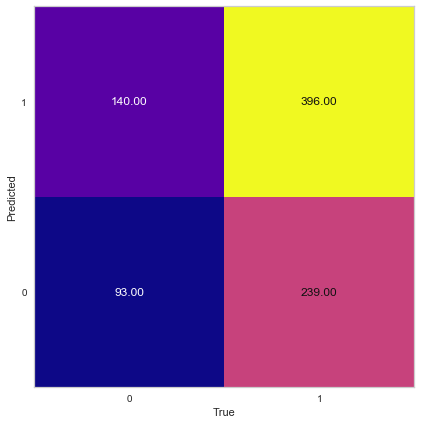

In [69]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
array =metrics.confusion_matrix(y_test_norm, voting_clf_JP.predict(X_test_norm))

personality_types = np.unique(y_test_norm)

df_cm = pd.DataFrame(array, index = [i for i in personality_types],
                  columns = [i for i in personality_types])

plt.figure(figsize = (7,7))
heatmap(array, xlabel='True', xticklabels=personality_types, ylabel='Predicted', yticklabels=personality_types, cmap="plasma")
plt.show()
